# K-Means

## Data Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random as rd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
#reading each xlsx and changing columns to match to then concat
df2014 = pd.read_excel('data/ttc-streetcar-delay-data-2014.xlsx')
df2015 = pd.read_excel('data/ttc-streetcar-delay-data-2015.xlsx')
df2016 = pd.read_excel('data/ttc-streetcar-delay-data-2016.xlsx')
df2017 = pd.read_excel('data/ttc-streetcar-delay-data-2017.xlsx')
df2018 = pd.read_excel('data/ttc-streetcar-delay-data-2018.xlsx')
df2019 = pd.read_excel('data/ttc-streetcar-delay-data-2019.xlsx')
df2020 = pd.read_excel('data/ttc-streetcar-delay-data-2020_final.xlsx').rename(columns={'Delay':'Min Delay',
                                                                                  'Gap':'Min Gap'})
df2021 = pd.read_excel('data/ttc-streetcar-delay-data-jan-2021-to-august-2021.xlsx').rename(columns={'Bound':'Direction',
                                                                                               'Date':'Report Date',
                                                                                               'Line':'Route'})

df2014['Time'] = pd.to_datetime(df2014['Time'], format='%H:%M:%S').dt.time
df2015['Time'] = pd.to_datetime(df2015['Time'], format='%H:%M:%S').dt.time
df2016['Time'] = pd.to_datetime(df2016['Time'], format='%H:%M:%S').dt.time
df2017['Time'] = pd.to_datetime(df2017['Time'], format='%H:%M:%S').dt.time
df2018['Time'] = pd.to_datetime(df2018['Time'], format='%H:%M:%S').dt.time
df2019['Time'] = pd.to_datetime(df2019['Time'], format='%H:%M:%S').dt.time
df2020['Time'] = pd.to_datetime(df2020['Time'], format='%H:%M:%S').dt.time
df2021['Time'] = pd.to_datetime(df2021['Time'], format='%H:%M:%S').dt.time

frames = [df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021]

In [59]:
df = pd.concat(frames)
df = df.rename(columns={'Report Date':'Report_Date','Min Delay':'Min_Delay','Min Gap':'Min_Gap',
                       'Round Time':'Round_Time'})

## Removing NAs

In [60]:
#summing na values
df.isna().sum()

Report_Date      0
Route            2
Time             0
Day              0
Location        21
Incident         0
Min_Delay        3
Min_Gap          5
Direction       98
Vehicle        503
Round_Time       0
dtype: int64

In [61]:
#removing vehicle as a column
df = df.drop('Vehicle', axis=1)

In [62]:
#removing na values
df = df.dropna()#.sample(frac = 1)
df = df.drop('Min_Gap', axis=1)

In [63]:
df = df.loc[~((df['Min_Delay'] == 0))]
df

Report_Date Route      Time       Day                        Location  \
0     2014-01-02   505  06:31:00  Thursday         Dundas and Roncesvalles   
1     2014-01-02   504  12:43:00  Thursday                   King and Shaw   
2     2014-01-02   501  14:01:00  Thursday       Kingston road and Bingham   
3     2014-01-02   504  14:22:00  Thursday  King St. and Roncesvalles Ave.   
4     2014-01-02   504  16:42:00  Thursday               King and Bathurst   
...          ...   ...       ...       ...                             ...   
1012  2021-01-31   512  22:10:00    Sunday                     GUNN'S LOOP   
1013  2021-01-31   501  22:43:00    Sunday             QUEEN AND BROADVIEW   
1014  2021-01-31   504  00:15:00    Sunday                KING AND SPADINA   
1016  2021-01-31   501  00:46:00    Sunday                QUEEN AND CHURCH   
1017  2021-01-31   510  01:23:00    Sunday             SPADINA AND COLLEGE   

                 Incident  Min_Delay Direction Round_Time  
0     Late Leaving Garage        4.0       E/B   06:30:00  
1      Utilized Off Route       20.0       E/B   12:30:00  
2                 Held By       13.0       W/B   14:00:00  
3           Investigation        7.0       W/B   14:30:00  
4      Utilized Off Route        3.0       E/B   16:30:00  
...                   ...        ...       ...        ...  
1012           Mechanical        5.0         E   22:00:00  
1013   Emergency Services       11.0         W   22:30:00  
1014           Mechanical        3.0         W   00:30:00  
1016              Held By       13.0         W   01:00:00  
1017             Cleaning       12.0         N   01:30:00  

[8744 rows x 9 columns]

## Datetime continuous

In [64]:
from datetime import timedelta

time_in_minutes = []
time_in_hours = []

for time in df['Time']:
    delta = timedelta(hours=int(time.strftime('%H')), 
                      minutes=int(time.strftime('%M')), 
                      seconds=int(time.strftime('%S')))
    total_seconds = delta.total_seconds()
    time_in_minutes.append(total_seconds/60)
    time_in_hours.append(total_seconds/60/60)

df['Time_in_hours'] = time_in_hours

## K-Means (day as dummy variable)

In [65]:
def clean_text(text):
    text = text.lower()
    text = text.replace(" ", "_")
    return text

df['Location'] = df['Location'].astype(str).apply(clean_text)
df['Incident'] = df['Incident'].astype(str).apply(clean_text)

In [67]:
day_data = df.drop(['Report_Date', 'Min_Delay', 'Direction', 'Incident',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Location'], axis=1)
day_data

Day
0     Thursday
1     Thursday
2     Thursday
3     Thursday
4     Thursday
...        ...
1012    Sunday
1013    Sunday
1014    Sunday
1016    Sunday
1017    Sunday

[8744 rows x 1 columns]

In [73]:
#encoded df
kmeans_dummy = df

for i in day_data:
    dummies = pd.get_dummies(day_data[i])
    kmeans_dummy = pd.concat([kmeans_dummy, dummies], axis=1)
    kmeans_dummy = kmeans_dummy.drop(i, axis=1)

kmeans_dummy = kmeans_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 
                                  'Location', 'Incident','Direction'], axis=1)

kmeans_dummy['Min_Delay'] = (kmeans_dummy['Min_Delay'] - kmeans_dummy['Min_Delay'].min()) / (kmeans_dummy['Min_Delay'].max() - kmeans_dummy['Min_Delay'].min())
kmeans_dummy['Time_in_hours'] = (kmeans_dummy['Time_in_hours'] - kmeans_dummy['Time_in_hours'].min()) / (kmeans_dummy['Time_in_hours'].max() - kmeans_dummy['Time_in_hours'].min())

kmeans_dummy

Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0      0.005008       0.271716       0       0         0       0         1   
1      0.031720       0.530229       0       0         0       0         1   
2      0.020033       0.584434       0       0         0       0         1   
3      0.010017       0.599027       0       0         0       0         1   
4      0.003339       0.696317       0       0         0       0         1   
...         ...            ...     ...     ...       ...     ...       ...   
1012   0.006678       0.924253       0       0         0       1         0   
1013   0.016694       0.947186       0       0         0       1         0   
1014   0.003339       0.010424       0       0         0       1         0   
1016   0.020033       0.031967       0       0         0       1         0   
1017   0.018364       0.057679       0       0         0       1         0   

      Tuesday  Wednesday  
0           0          0  
1           0          0  
2           0          0  
3           0          0  
4           0          0  
...       ...        ...  
1012        0          0  
1013        0          0  
1014        0          0  
1016        0          0  
1017        0          0  

[8744 rows x 9 columns]

In [70]:
# Try various values of k
sil_scores_day = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(kmeans_dummy)
    label = clusterer.predict(kmeans_dummy)
    sil_scores_day.append({'k':k, 'silhouette_score':silhouette_score(kmeans_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores_day = pd.DataFrame(sil_scores_day)
best_label_day = sil_scores_day.loc[sil_scores_day['silhouette_score'].idxmax(),'label']
best_label_day

# Present some summary statistics for each clusters
df.groupby(best_label_day).mean()

Min_Delay  Time_in_hours
0  10.807794      11.287043
1   9.773773      12.060008
2  10.689432      11.729176
3  11.062268      11.824388
4  12.054980      11.878048
5  11.875000      13.102640
6  13.366931      11.999604

In [71]:
df.groupby(best_label_day).describe()

Min_Delay                                                   Time_in_hours  \
      count       mean        std  min  25%  50%   75%    max         count   
0    1514.0  10.807794  24.510988  1.0  4.0  6.0  10.0  492.0        1514.0   
1    1304.0   9.773773  12.874990  1.0  4.0  6.0  10.0  182.0        1304.0   
2    1391.0  10.689432  17.574913  1.0  4.0  6.0  10.0  285.0        1391.0   
3    1349.0  11.062268  21.657654  1.0  5.0  6.0  10.0  418.0        1349.0   
4    1255.0  12.054980  24.524948  1.0  5.0  6.0  10.0  600.0        1255.0   
5    1048.0  11.875000  21.828161  1.0  5.0  7.0  10.0  529.0        1048.0   
6     883.0  13.366931  30.760709  1.0  6.0  8.0  10.0  502.0         883.0   

                                                                             
        mean       std       min       25%        50%        75%        max  
0  11.287043  5.513108  0.000000  6.733333   9.683333  15.679167  23.983333  
1  12.060008  5.577925  0.100000  7.233333  11.250000  16.325000  23.966667  
2  11.729176  5.971358  0.000000  6.616667  11.083333  16.225000  23.983333  
3  11.824388  5.825807  0.050000  6.733333  11.183333  16.516667  23.983333  
4  11.878048  5.781947  0.083333  6.783333  11.550000  16.416667  23.966667  
5  13.102640  5.770123  0.016667  8.962500  13.191667  17.591667  23.983333  
6  11.999604  6.136583  0.050000  7.633333  11.533333  17.166667  23.950000

In [74]:
sil_scores_day

k  silhouette_score                                              label
0   5          0.614087  [4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, ...
1   6          0.719730  [5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, ...
2   7          0.807721  [4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, ...
3   8          0.781350  [5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, ...
4   9          0.755754  [4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, ...
5  10          0.732768  [4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, ...
6  11          0.710229  [0, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, ...
7  12          0.685643  [9, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, ...
8  13          0.665437  [10, 3, 3, 3, 3, 3, 3, 3, 9, 9, 9, 9, 9, 9, 9,...
9  14          0.635117  [4, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, ...

For k = 5 The average silhouette_score is : 0.6140872285773545
For k = 6 The average silhouette_score is : 0.7197298573823311
For k = 7 The average silhouette_score is : 0.8077212420638848
For k = 8 The average silhouette_score is : 0.781350444389208
For k = 9 The average silhouette_score is : 0.7557540267084197
For k = 10 The average silhouette_score is : 0.732685884818419
For k = 11 The average silhouette_score is : 0.7101518204047389
For k = 12 The average silhouette_score is : 0.6856427854972571
For k = 13 The average silhouette_score is : 0.6553990312201048
For k = 14 The average silhouette_score is : 0.6351874646670748


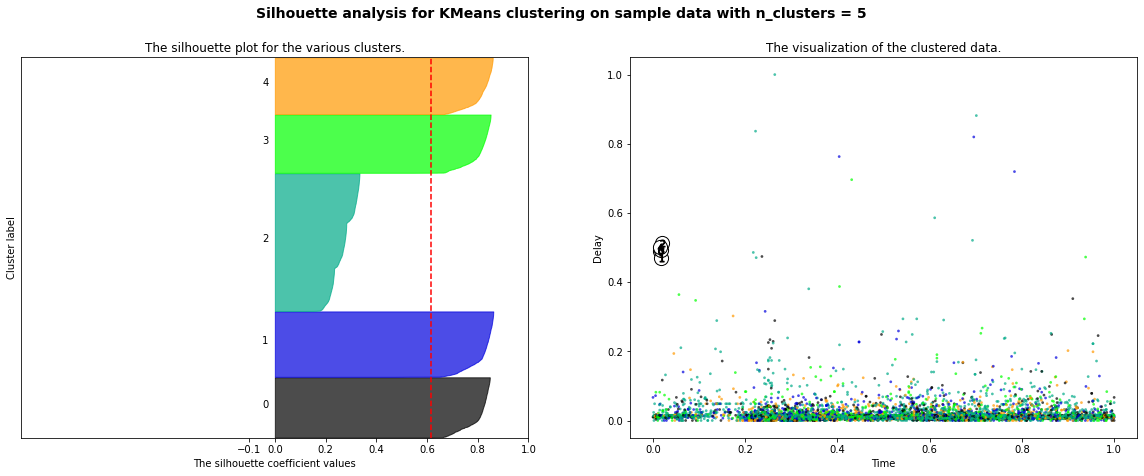

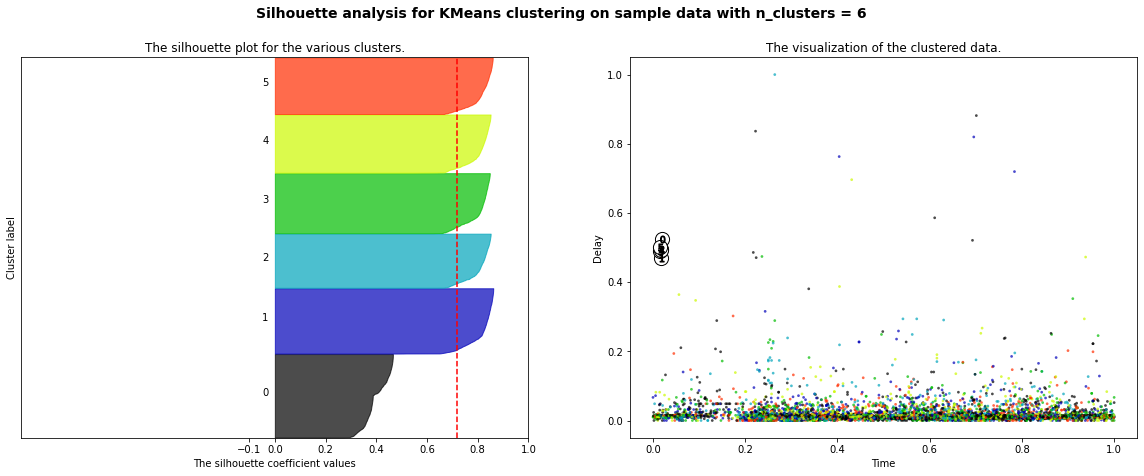

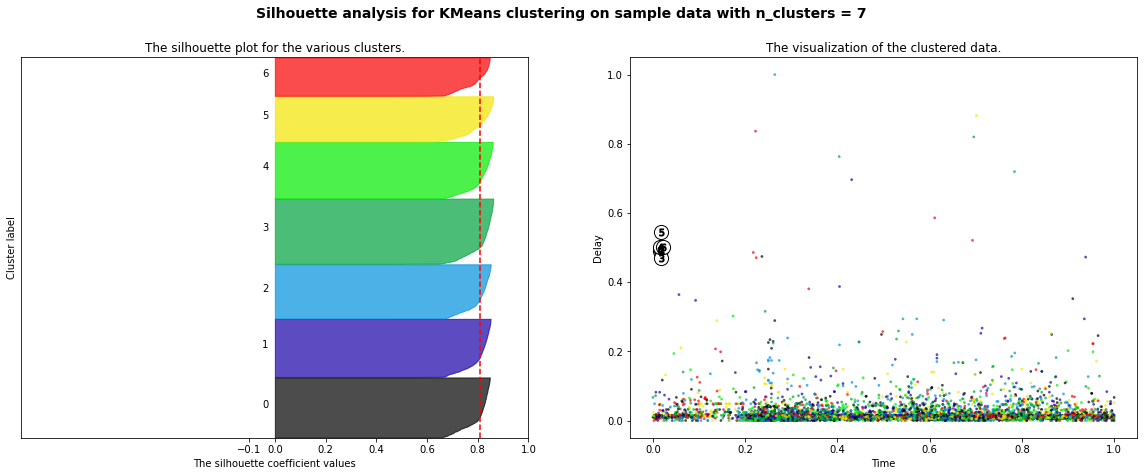

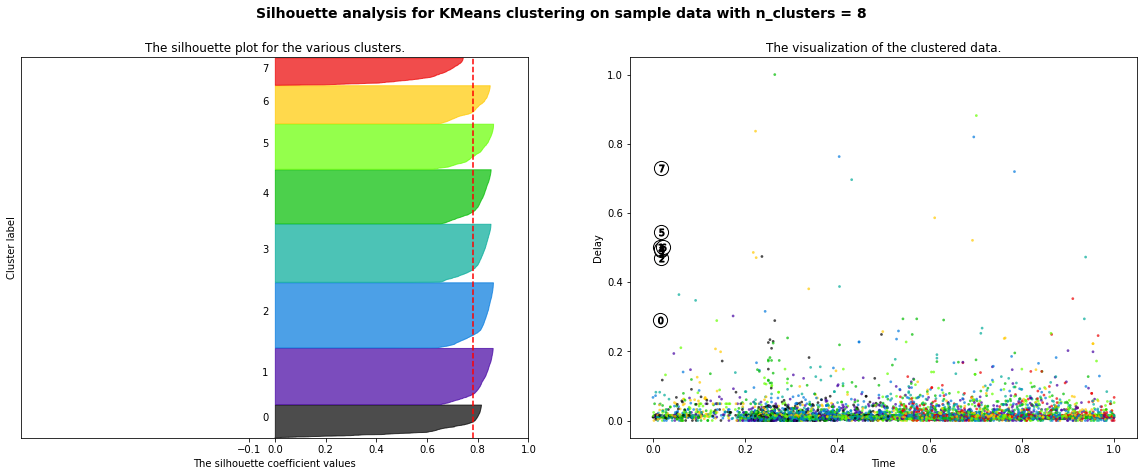

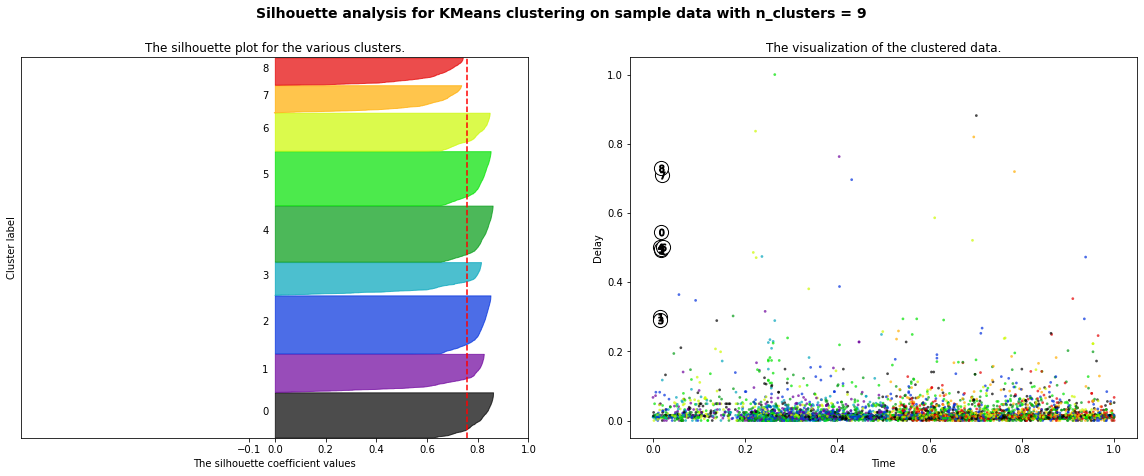

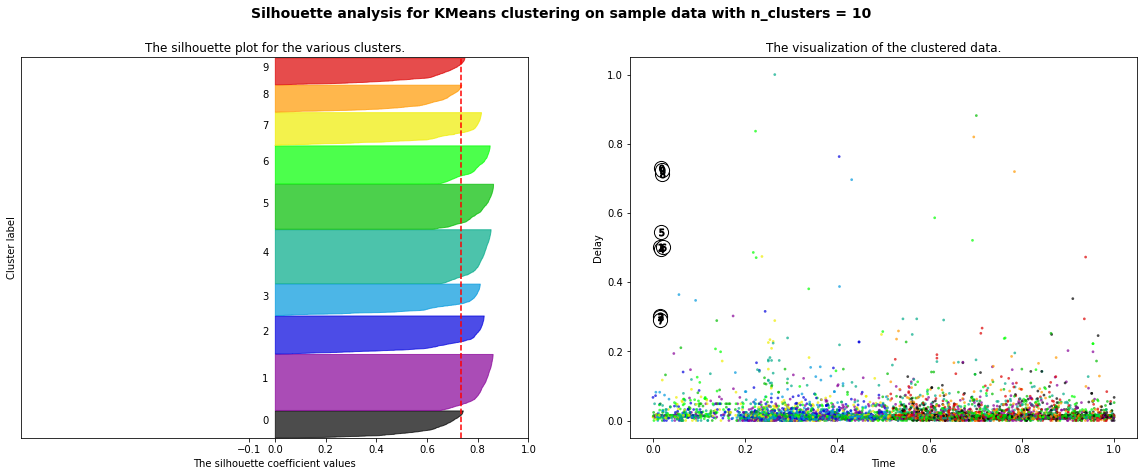

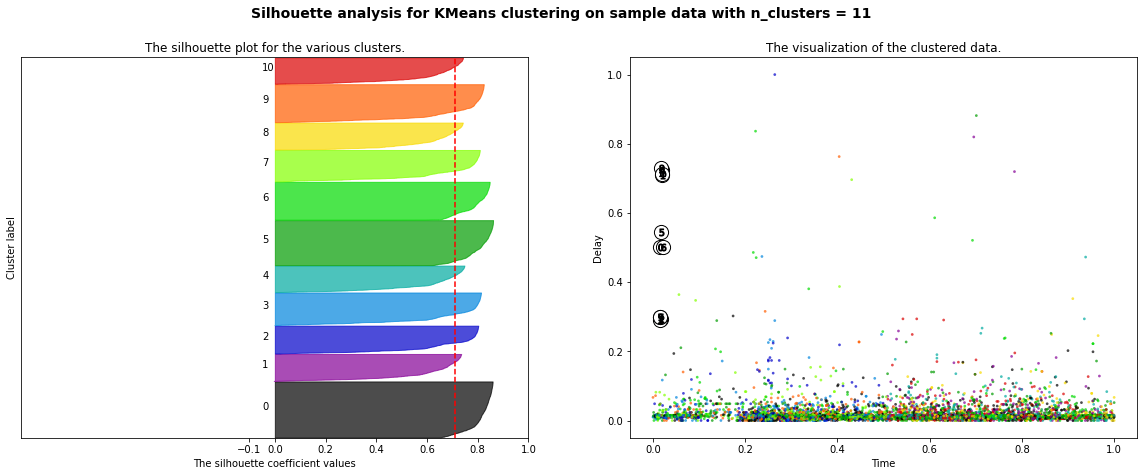

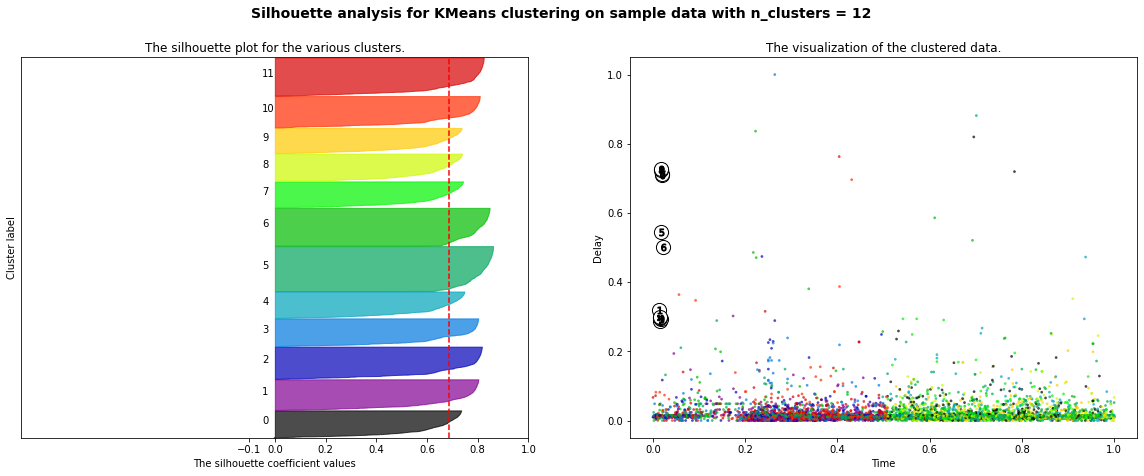

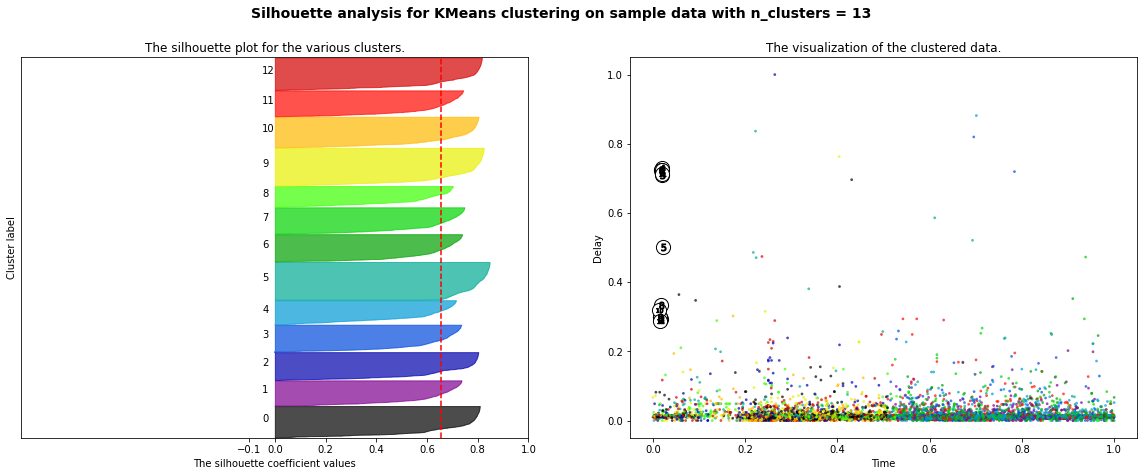

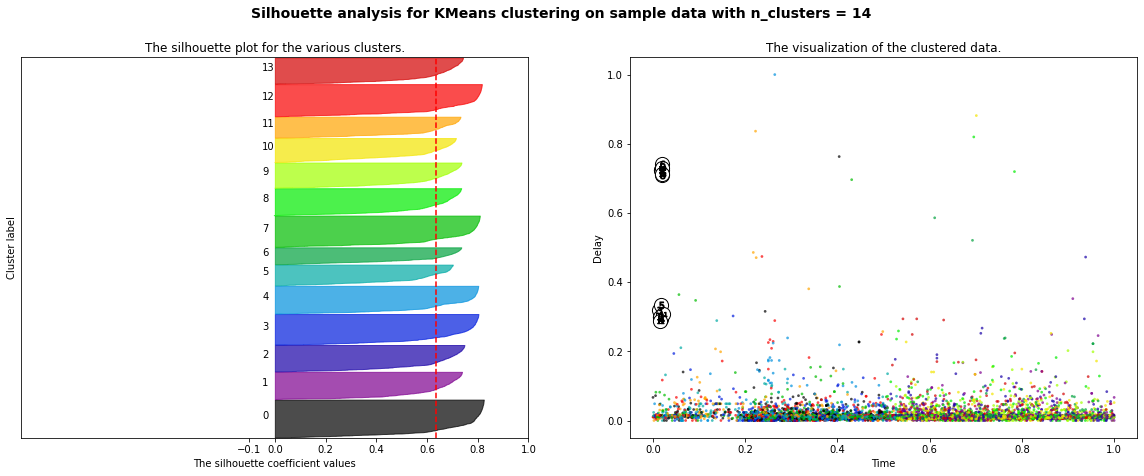

In [120]:
X, y = kmeans_dummy['Time_in_hours'], kmeans_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(kmeans_dummy)
    cluster_labels = clusterer.predict(kmeans_dummy)
    
    silhouette_avg = silhouette_score(kmeans_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(kmeans_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        kmeans_dummy['Time_in_hours'], kmeans_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Delay")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

## K-Means (location as dummy variable)

In [76]:
location_data = df.drop(['Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Incident'], axis=1)
location_data

Location
0            dundas_and_roncesvalles
1                      king_and_shaw
2          kingston_road_and_bingham
3     king_st._and_roncesvalles_ave.
4                  king_and_bathurst
...                              ...
1012                     gunn's_loop
1013             queen_and_broadview
1014                king_and_spadina
1016                queen_and_church
1017             spadina_and_college

[8744 rows x 1 columns]

In [78]:
#encoded df
location_dummy = df

for i in location_data:
    dummies = pd.get_dummies(location_data[i])
    location_dummy = pd.concat([location_dummy, dummies], axis=1)
    location_dummy = location_dummy.drop(i, axis=1)

location_dummy = location_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Incident', 
                                      'Direction', 'Day'], axis=1)

location_dummy['Min_Delay'] = (location_dummy['Min_Delay'] - location_dummy['Min_Delay'].min()) / (location_dummy['Min_Delay'].max() - location_dummy['Min_Delay'].min())
location_dummy['Time_in_hours'] = (location_dummy['Time_in_hours'] - location_dummy['Time_in_hours'].min()) / (location_dummy['Time_in_hours'].max() - location_dummy['Time_in_hours'].min())

location_dummy


Min_Delay  Time_in_hours  1st_and_lakeshore  28th_street_and_lakeshore  \
0      0.005008       0.271716                  0                          0   
1      0.031720       0.530229                  0                          0   
2      0.020033       0.584434                  0                          0   
3      0.010017       0.599027                  0                          0   
4      0.003339       0.696317                  0                          0   
...         ...            ...                ...                        ...   
1012   0.006678       0.924253                  0                          0   
1013   0.016694       0.947186                  0                          0   
1014   0.003339       0.010424                  0                          0   
1016   0.020033       0.031967                  0                          0   
1017   0.018364       0.057679                  0                          0   

      37th_/_lakeshore  37th_street_and_lakeshore  40th_/_lakeshore  \
0                    0                          0                 0   
1                    0                          0                 0   
2                    0                          0                 0   
3                    0                          0                 0   
4                    0                          0                 0   
...                ...                        ...               ...   
1012                 0                          0                 0   
1013                 0                          0                 0   
1014                 0                          0                 0   
1016                 0                          0                 0   
1017                 0                          0                 0   

      506_carlton  5th_/_lakeshore  5th_and_lakeshore  ...  york  york/_queen  \
0               0                0                  0  ...     0            0   
1               0                0                  0  ...     0            0   
2               0                0                  0  ...     0            0   
3               0                0                  0  ...     0            0   
4               0                0                  0  ...     0            0   
...           ...              ...                ...  ...   ...          ...   
1012            0                0                  0  ...     0            0   
1013            0                0                  0  ...     0            0   
1014            0                0                  0  ...     0            0   
1016            0                0                  0  ...     0            0   
1017            0                0                  0  ...     0            0   

      york_/_adelaide  york_/_queen  york_and_king  york_and_queen  \
0                   0             0              0               0   
1                   0             0              0               0   
2                   0             0              0               0   
3                   0             0              0               0   
4                   0             0              0               0   
...               ...           ...            ...             ...   
1012                0             0              0               0   
1013                0             0              0               0   
1014                0             0              0               0   
1016                0             0              0               0   
1017                0             0              0               0   

      york_and_queens_quay  york_and_queensquay  young_and_dundas  yoyoma  
0                        0                    0                 0       0  
1                        0                    0                 0       0  
2                        0                    0                 0       0  
3                        0                    0                 0       0 

In [79]:
# Try various values of k
sil_scores_location = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    label = clusterer.predict(location_dummy)
    sil_scores_location.append({'k':k, 'silhouette_score':silhouette_score(location_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores_location = pd.DataFrame(sil_scores_location)
best_label_location = sil_scores_location.loc[sil_scores_location['silhouette_score'].idxmax(),'label'] 
best_label_location

# Present some summary statistics for each clusters
df.groupby(best_label_location).mean()

Min_Delay  Time_in_hours
0    7.442623       7.968579
1   11.481230       6.430419
2    5.851852       7.845542
3    7.070064      13.130467
4    6.152672       8.112087
5    6.536232       8.968599
6    8.494318      13.141572
7    5.911765      10.615033
8   13.531659      19.949773
9   11.262663      13.609368
10   5.795580       9.366943
11   7.170213       9.604255
12  15.860870       7.046667

In [80]:
df.groupby(best_label_location).describe()

Min_Delay                                                   Time_in_hours  \
       count       mean        std  min  25%  50%   75%    max         count   
0      183.0   7.442623   9.978314  1.0  4.0  5.0   6.0   75.0         183.0   
1     2797.0  11.481230  22.342440  1.0  5.0  6.0  10.0  502.0        2797.0   
2      243.0   5.851852   3.023781  1.0  4.0  6.0   6.0   23.0         243.0   
3      157.0   7.070064   5.161637  1.0  5.0  6.0   8.0   41.0         157.0   
4      131.0   6.152672   3.014001  1.0  5.0  6.0   6.0   24.0         131.0   
5      138.0   6.536232   2.969822  2.0  5.0  5.0   8.0   22.0         138.0   
6      176.0   8.494318   8.294575  1.0  4.0  6.0   8.0   42.0         176.0   
7      102.0   5.911765   3.629098  1.0  4.0  4.5   7.0   15.0         102.0   
8     1911.0  13.531659  26.574501  1.0  5.0  7.0  12.0  529.0        1911.0   
9     2448.0  11.262663  19.627780  1.0  5.0  6.0  10.0  418.0        2448.0   
10     181.0   5.795580   3.186287  1.0  4.0  5.0   6.0   17.0         181.0   
11      47.0   7.170213   6.608029  2.0  4.0  5.0   8.5   44.0          47.0   
12     230.0  15.860870  47.070585  1.0  3.0  8.0   9.0  600.0         230.0   

                                                                                
         mean       std        min        25%        50%        75%        max  
0    7.968579  3.578974   4.916667   5.800000   6.416667   8.208333  21.150000  
1    6.430419  2.481427   0.000000   5.583333   6.816667   8.200000  10.350000  
2    7.845542  3.546575   3.950000   5.766667   6.433333   8.266667  23.500000  
3   13.130467  5.607419   0.233333   8.450000  13.866667  17.550000  23.683333  
4    8.112087  3.337956   4.150000   5.783333   6.450000  10.508333  16.916667  
5    8.968599  4.314070   1.200000   5.879167   7.083333  11.166667  20.250000  
6   13.141572  5.957446   0.166667   8.250000  13.916667  17.729167  23.916667  
7   10.615033  4.113521   5.100000   6.791667   9.350000  14.708333  19.766667  
8   19.949773  2.030184  16.150000  18.216667  19.666667  21.533333  23.983333  
9   13.609368  1.941076   9.583333  11.995833  13.791667  15.250000  17.483333  
10   9.366943  4.404390   4.800000   6.216667   7.333333  13.000000  23.466667  
11   9.604255  4.658189   0.133333   7.625000   8.333333   9.725000  23.483333  
12   7.046667  2.051909   1.566667   5.900000   6.250000   7.779167  15.450000

In [81]:
sil_scores_location

k  silhouette_score                                              label
0   5          0.069341  [1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 1, ...
1   6          0.073565  [3, 0, 0, 0, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, ...
2   7          0.085269  [5, 1, 1, 1, 4, 4, 4, 4, 5, 5, 3, 5, 3, 5, 5, ...
3   8          0.103053  [6, 5, 5, 5, 0, 0, 0, 0, 6, 6, 1, 6, 1, 6, 6, ...
4   9          0.116818  [4, 0, 0, 0, 7, 7, 7, 7, 4, 4, 6, 4, 6, 4, 4, ...
5  10          0.117306  [2, 5, 5, 5, 5, 4, 4, 4, 2, 2, 6, 2, 6, 2, 2, ...
6  11          0.131583  [4, 9, 9, 9, 7, 7, 7, 7, 4, 4, 6, 4, 6, 0, 4, ...
7  12          0.141246  [10, 9, 9, 9, 9, 1, 1, 1, 0, 10, 4, 10, 4, 2, ...
8  13          0.152894  [1, 9, 9, 9, 8, 8, 8, 8, 1, 1, 10, 1, 10, 7, 1...
9  14          0.149428  [13, 5, 5, 5, 5, 5, 10, 10, 13, 13, 6, 13, 6, ...

For k = 5 The average silhouette_score is : 0.052231046158271247
For k = 6 The average silhouette_score is : 0.06600879658324636
For k = 7 The average silhouette_score is : 0.08580403544877353
For k = 8 The average silhouette_score is : 0.09894145135982138
For k = 9 The average silhouette_score is : 0.11263269792893982
For k = 10 The average silhouette_score is : 0.11847666887757677
For k = 11 The average silhouette_score is : 0.13863715186356082
For k = 12 The average silhouette_score is : 0.14534163431912622
For k = 13 The average silhouette_score is : 0.1506409597939261
For k = 14 The average silhouette_score is : 0.15381033249185708


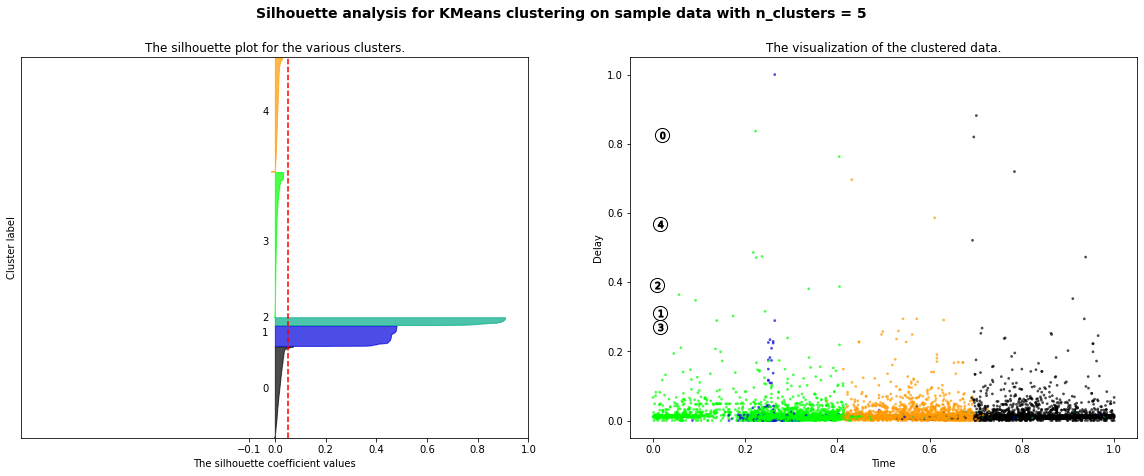

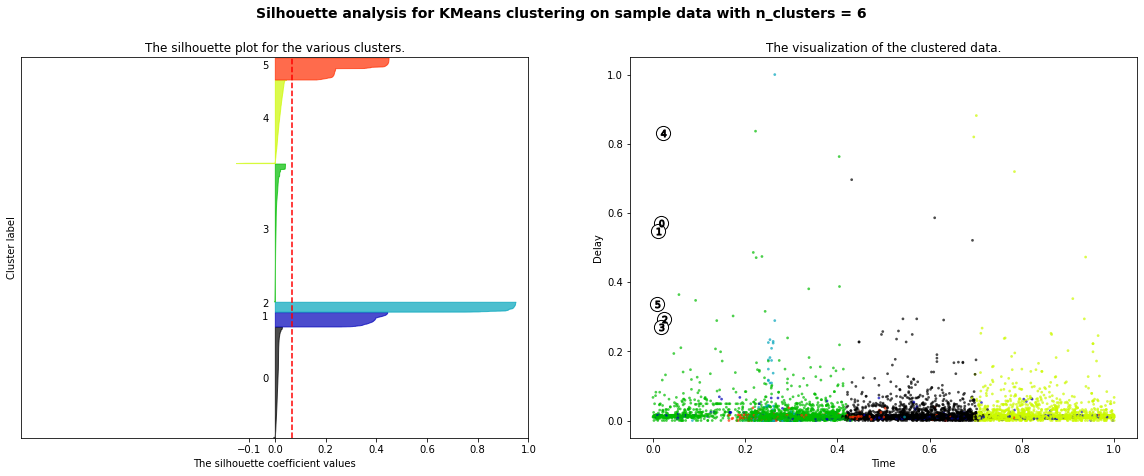

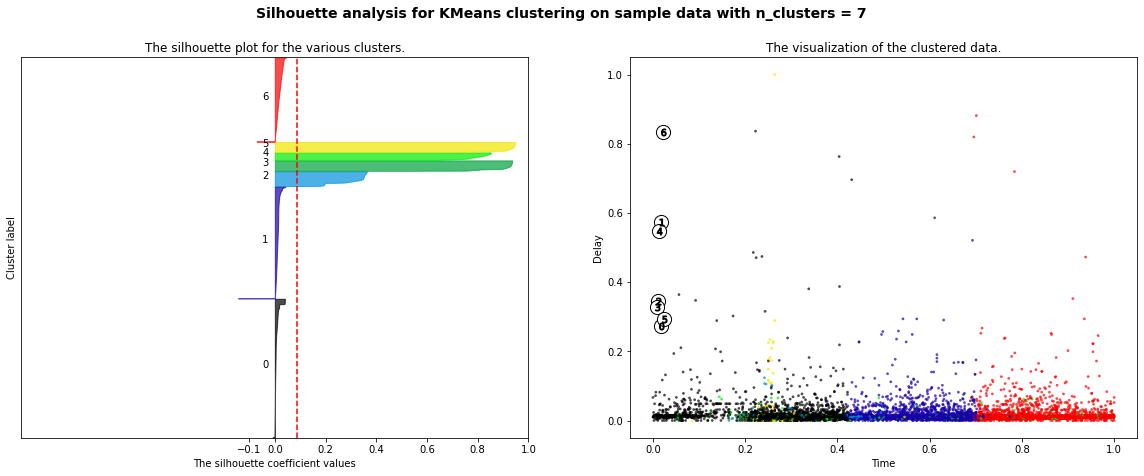

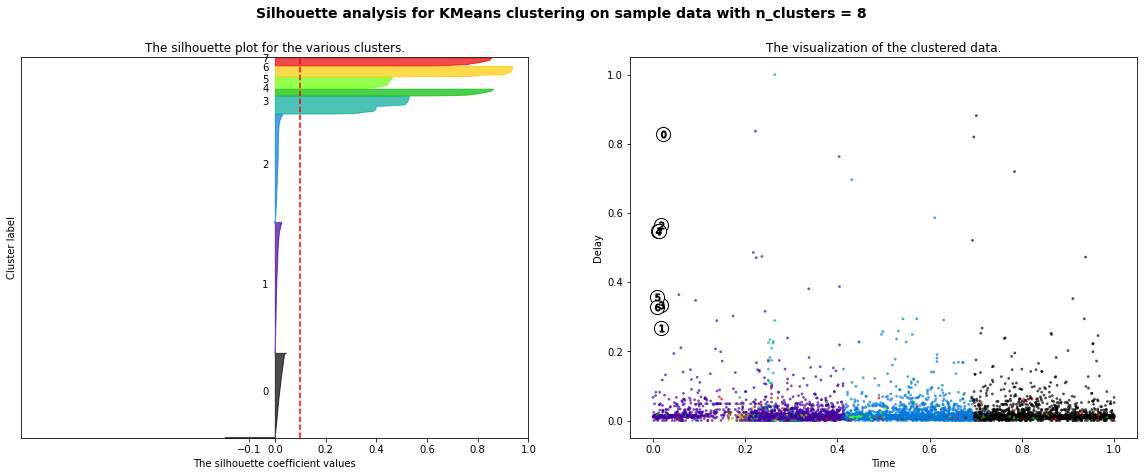

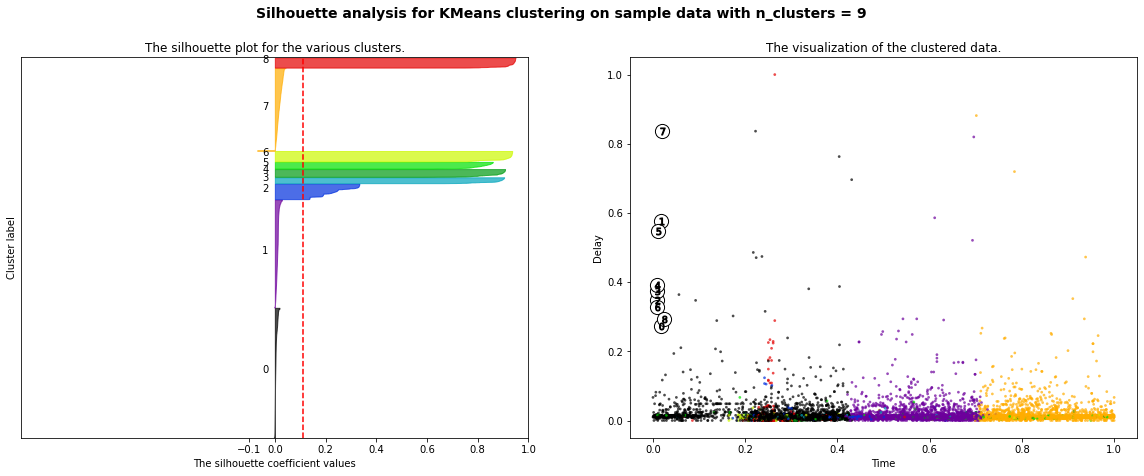

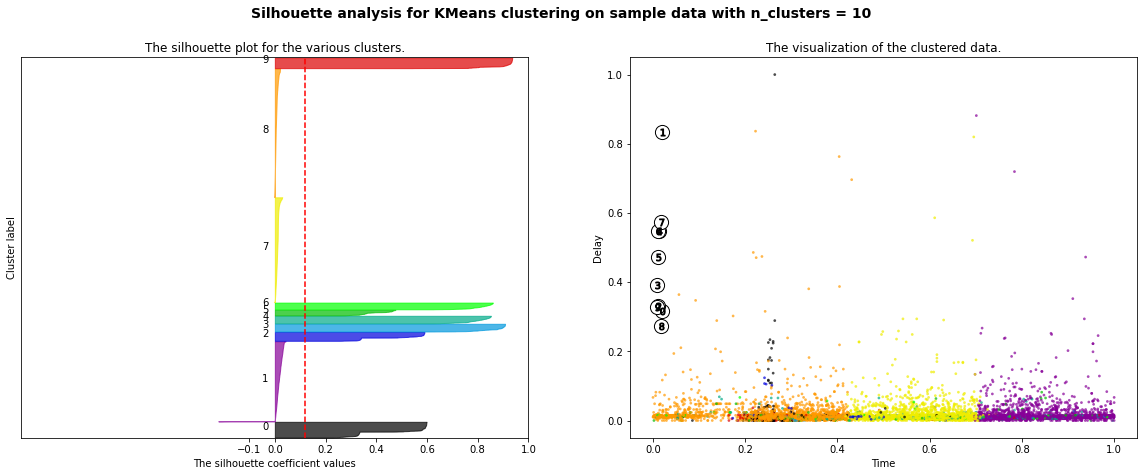

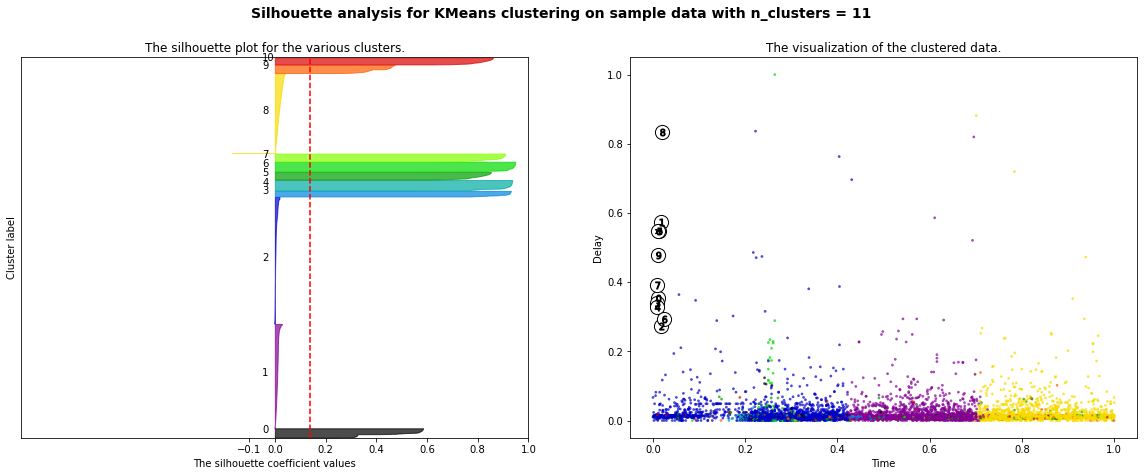

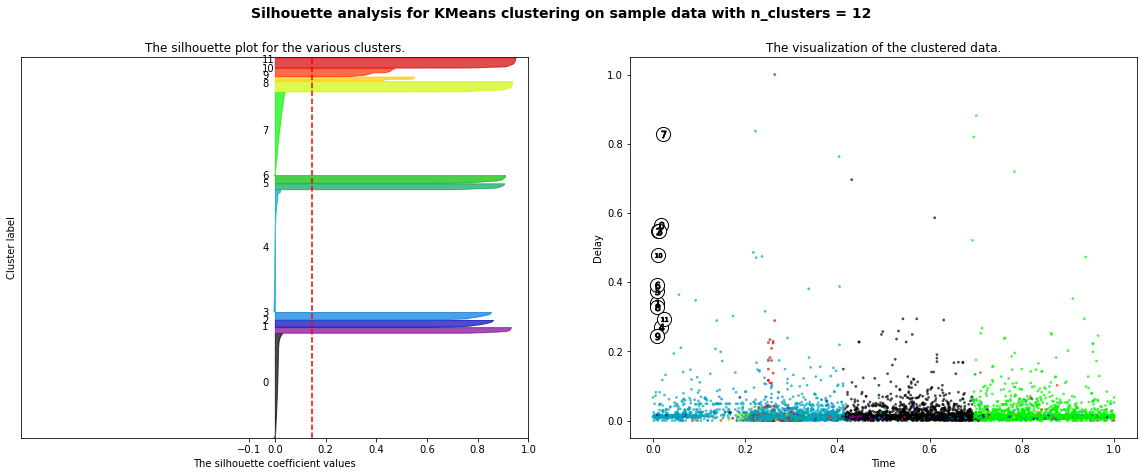

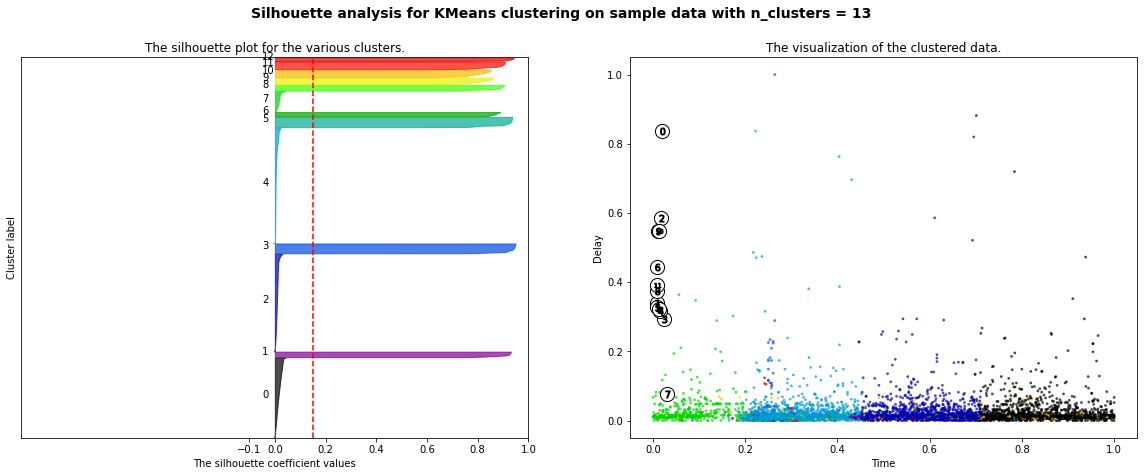

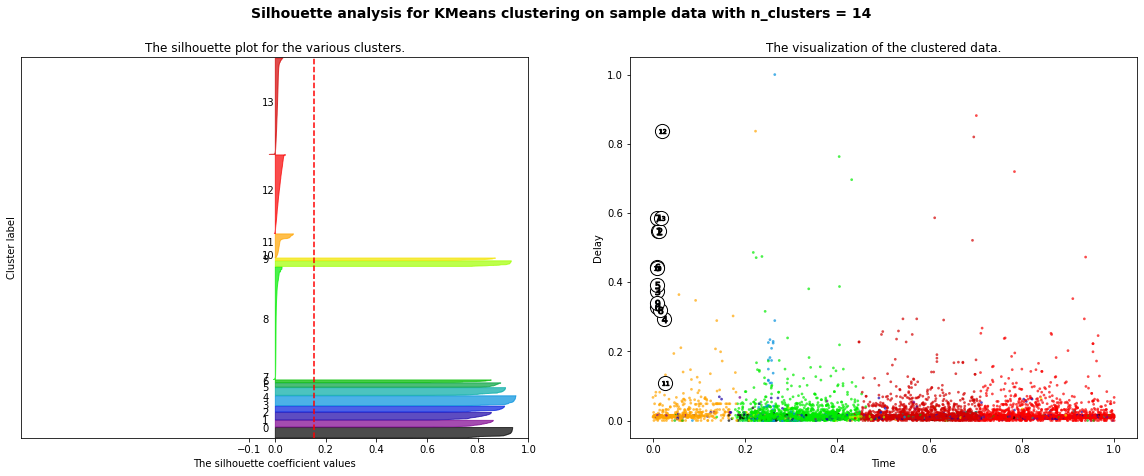

In [121]:
X, y = location_dummy['Time_in_hours'], location_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    cluster_labels = clusterer.predict(location_dummy)
    
    silhouette_avg = silhouette_score(location_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(location_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        location_dummy['Time_in_hours'], location_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Delay")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

For k = 15 The average silhouette_score is : 0.1514121819485271
For k = 16 The average silhouette_score is : 0.16397393733531715
For k = 17 The average silhouette_score is : 0.16391761013321993
For k = 18 The average silhouette_score is : 0.18213886831919923
For k = 19 The average silhouette_score is : 0.17687823554686957
For k = 20 The average silhouette_score is : 0.17350243371752502
For k = 21 The average silhouette_score is : 0.18778642764124254
For k = 22 The average silhouette_score is : 0.19493556180412527
For k = 23 The average silhouette_score is : 0.20202172589653902
For k = 24 The average silhouette_score is : 0.1984818061489722
For k = 25 The average silhouette_score is : 0.203786284219238
For k = 26 The average silhouette_score is : 0.21135344019009908
For k = 27 The average silhouette_score is : 0.20995180397035088
For k = 28 The average silhouette_score is : 0.21884257530263718
For k = 29 The average silhouette_score is : 0.2225681326289129


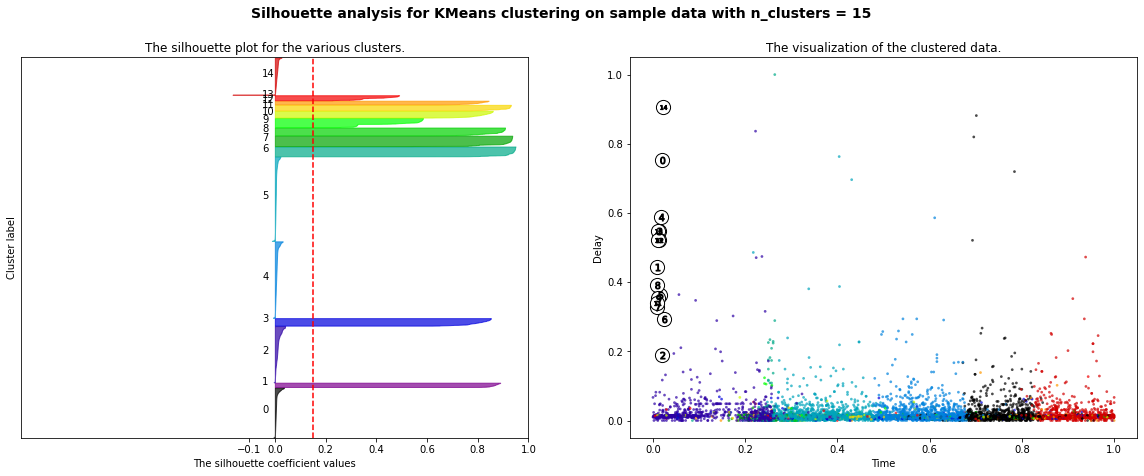

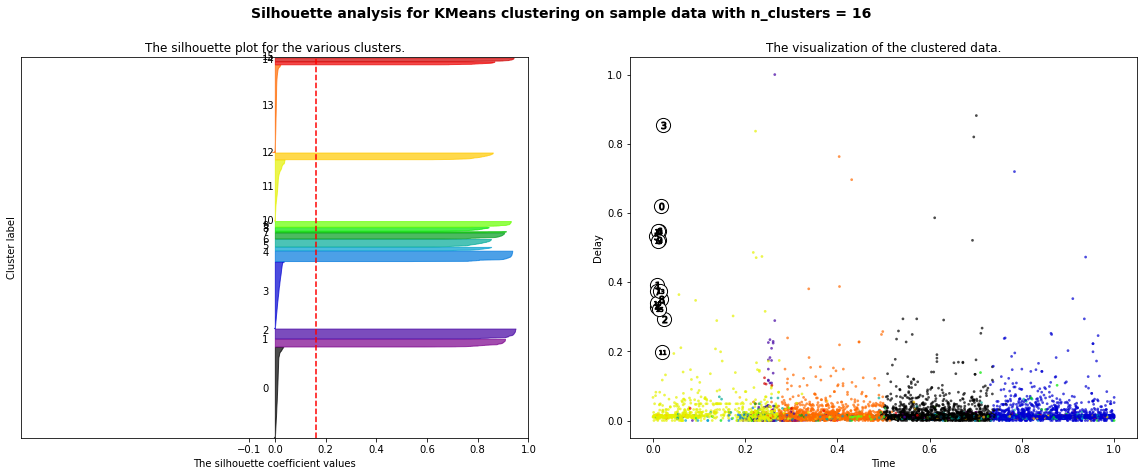

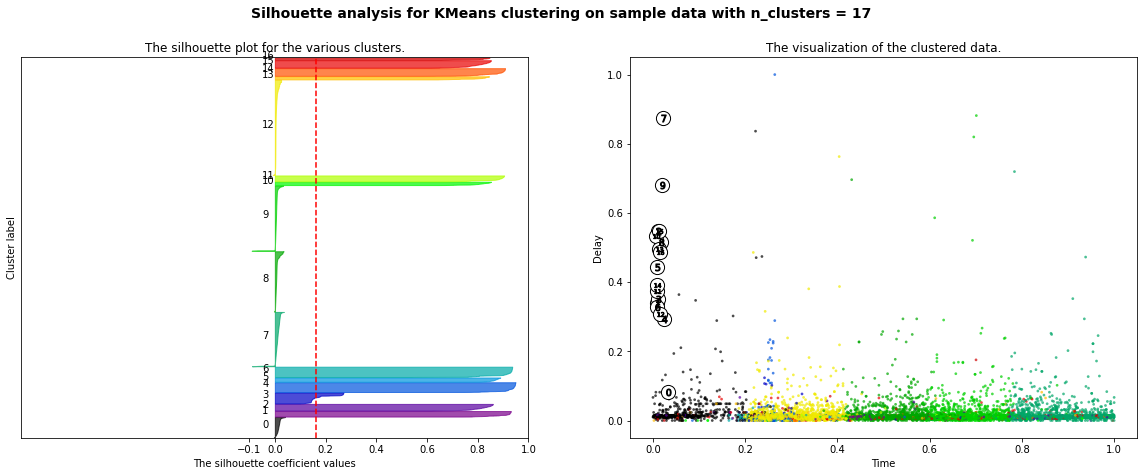

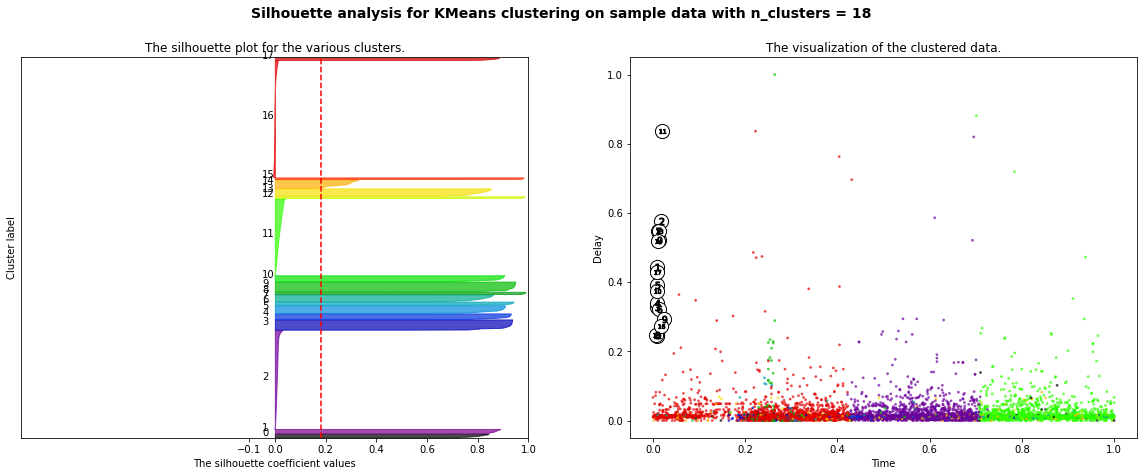

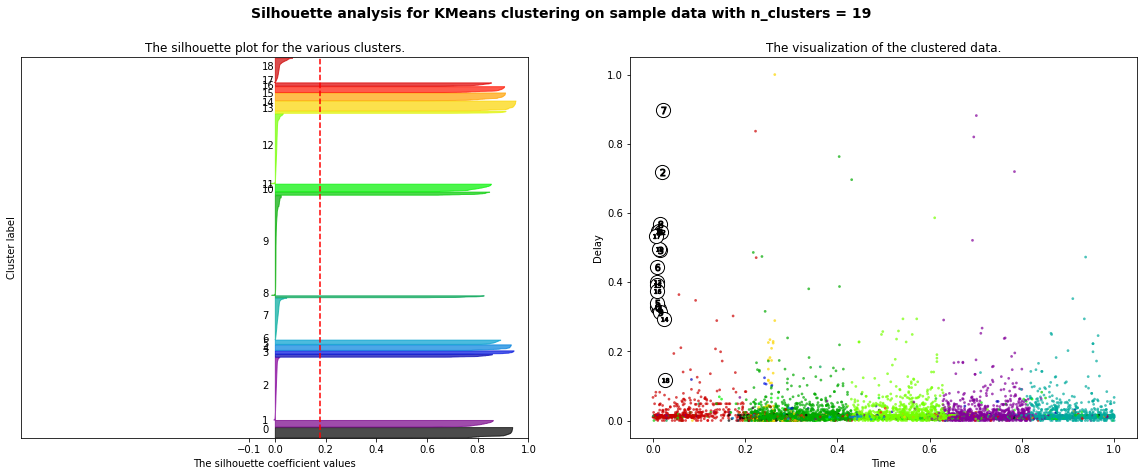

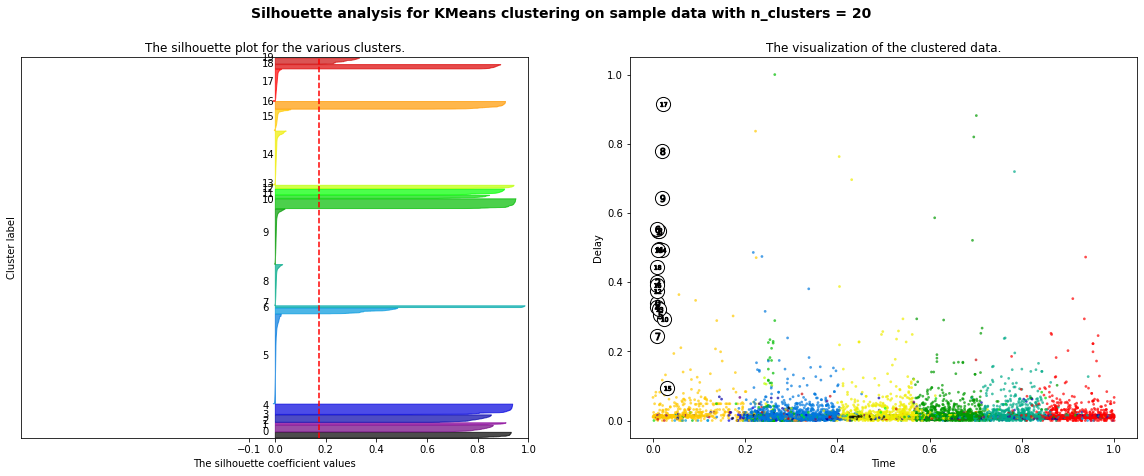

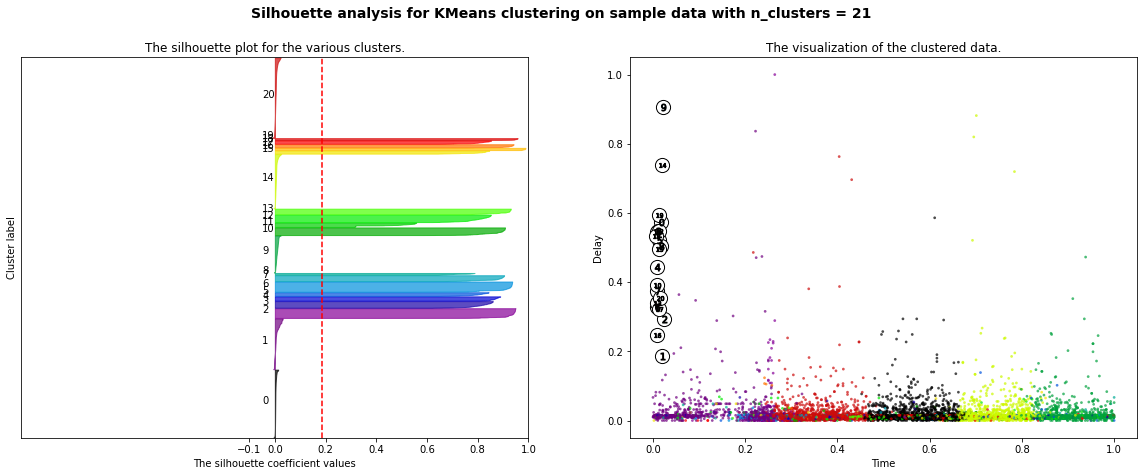

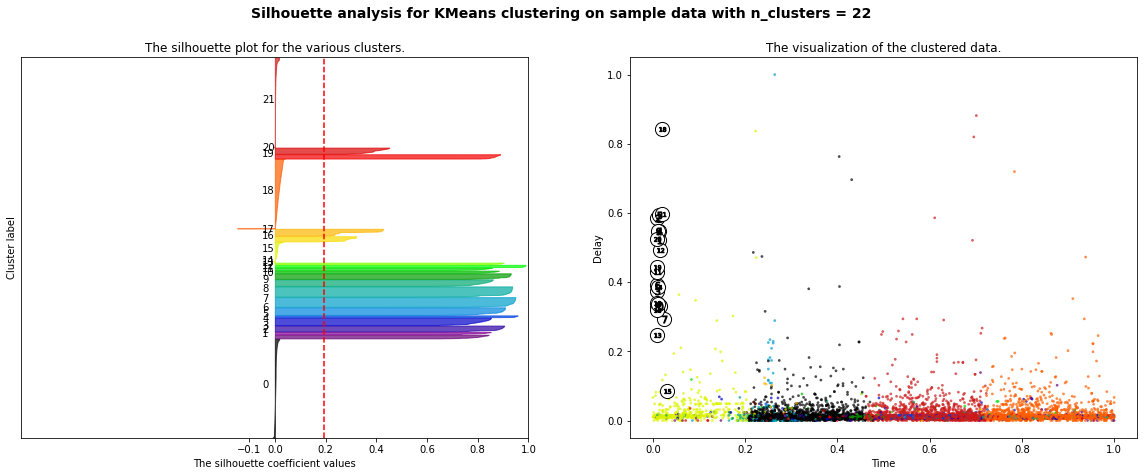

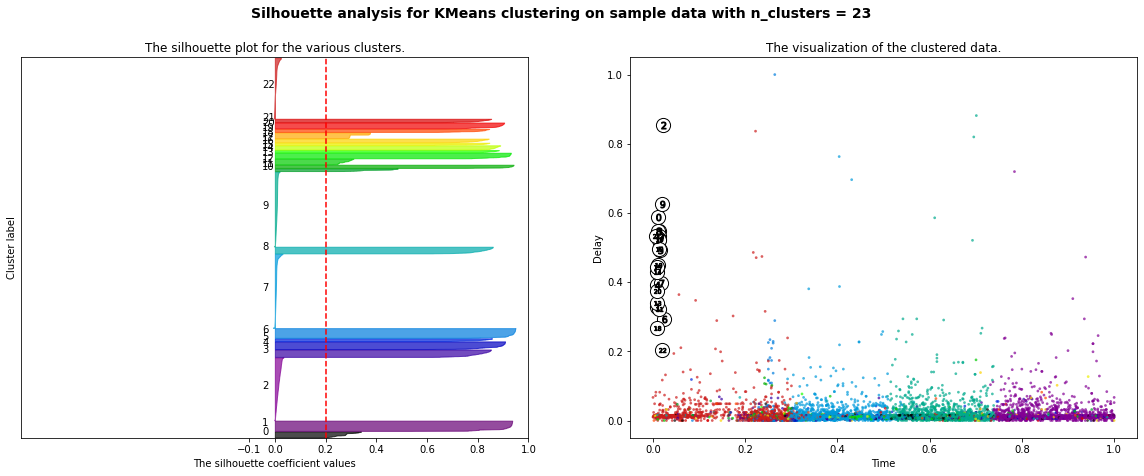

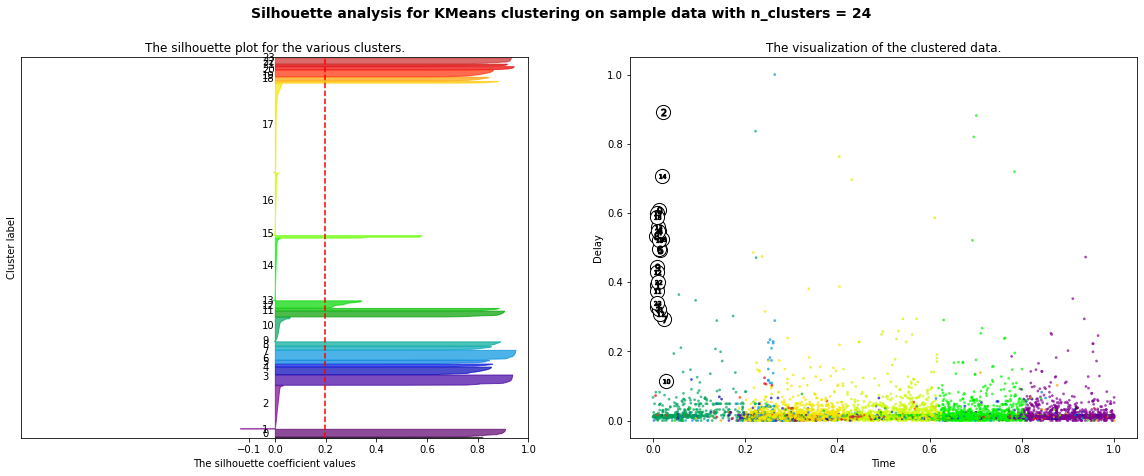

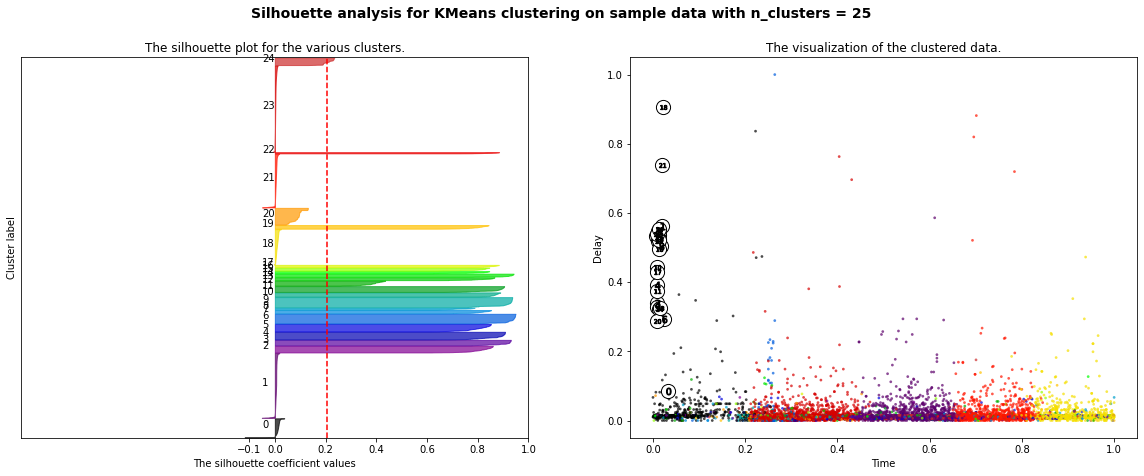

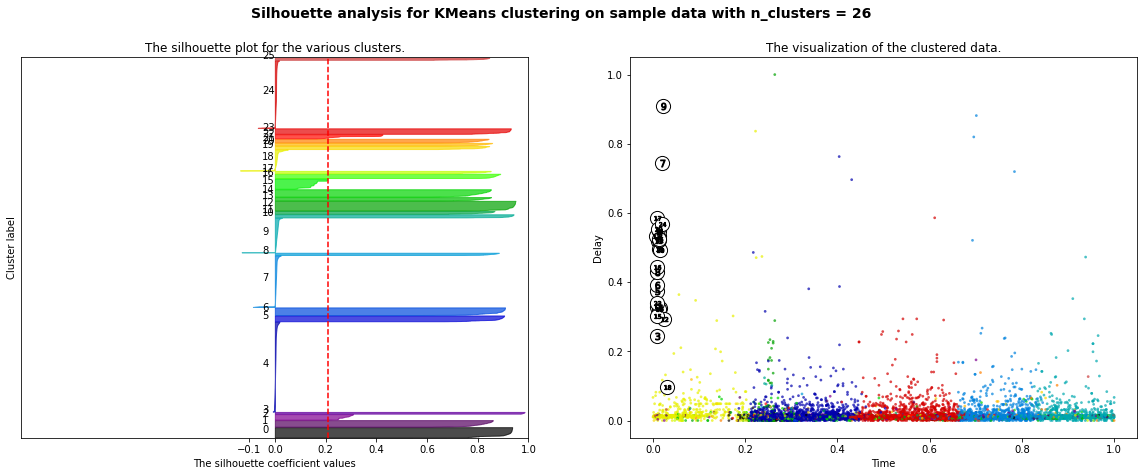

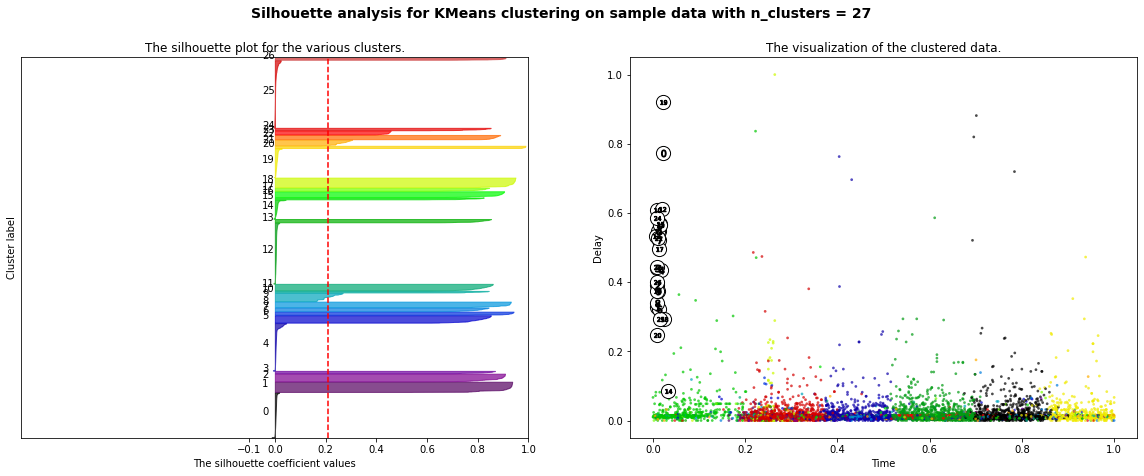

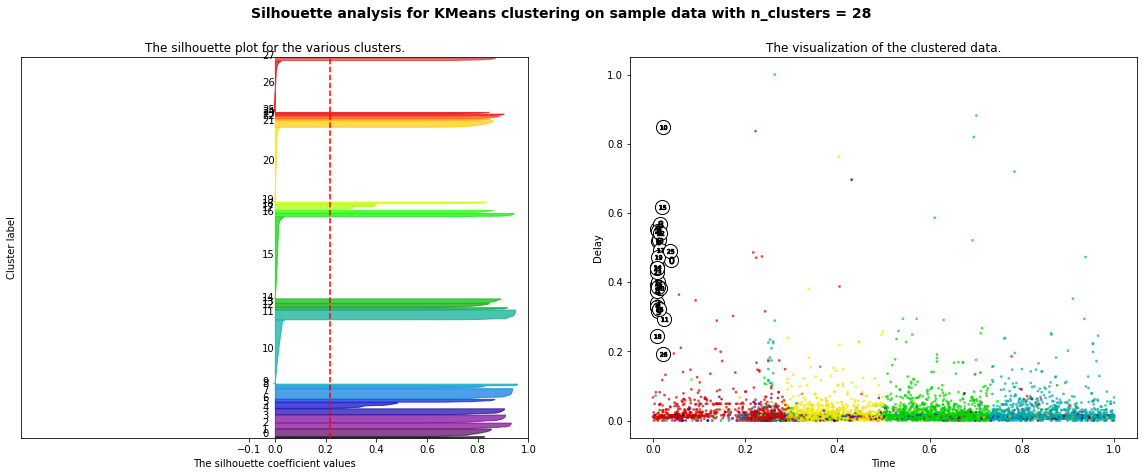

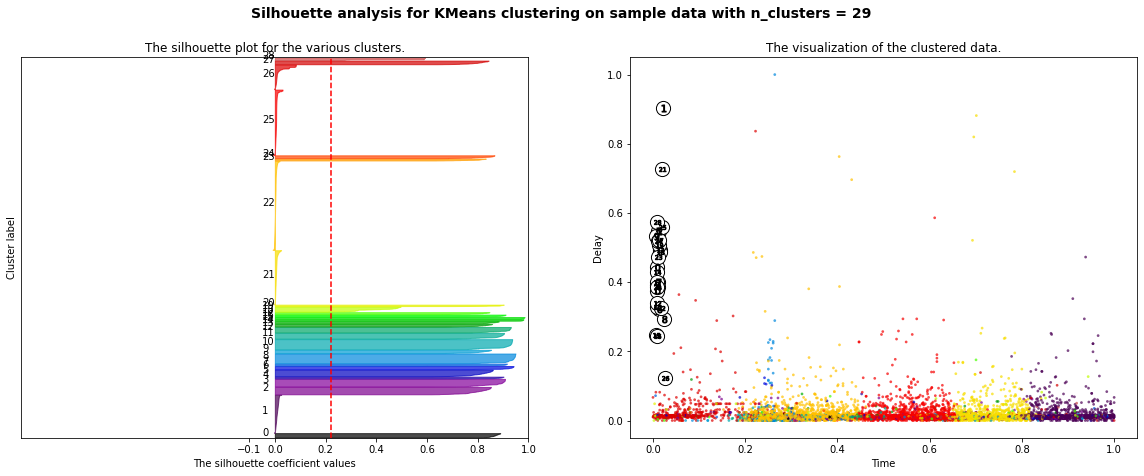

In [122]:
X, y = location_dummy['Time_in_hours'], location_dummy['Min_Delay']

for k in range(15,30):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    cluster_labels = clusterer.predict(location_dummy)
    
    silhouette_avg = silhouette_score(location_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(location_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        location_dummy['Time_in_hours'], location_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Delay")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

## K-Means (incident as dummy variables)

In [84]:
incident_data = df.drop(['Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Location'], axis=1)
incident_data

Incident
0     late_leaving_garage
1      utilized_off_route
2                 held_by
3           investigation
4      utilized_off_route
...                   ...
1012           mechanical
1013   emergency_services
1014           mechanical
1016              held_by
1017             cleaning

[8744 rows x 1 columns]

In [86]:
#encoded df
incident_dummy = df

for i in incident_data:
    dummies = pd.get_dummies(incident_data[i])
    incident_dummy = pd.concat([incident_dummy, dummies], axis=1)
    incident_dummy = incident_dummy.drop(i, axis=1)

incident_dummy = incident_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Day',
                                      'Direction', 'Location'], axis=1)

incident_dummy['Min_Delay'] = (incident_dummy['Min_Delay'] - incident_dummy['Min_Delay'].min()) / (incident_dummy['Min_Delay'].max() - incident_dummy['Min_Delay'].min())
incident_dummy['Time_in_hours'] = (incident_dummy['Time_in_hours'] - incident_dummy['Time_in_hours'].min()) / (incident_dummy['Time_in_hours'].max() - incident_dummy['Time_in_hours'].min())

incident_dummy


Min_Delay  Time_in_hours  cleaning  collision_-_ttc_involved  diversion  \
0      0.005008       0.271716         0                         0          0   
1      0.031720       0.530229         0                         0          0   
2      0.020033       0.584434         0                         0          0   
3      0.010017       0.599027         0                         0          0   
4      0.003339       0.696317         0                         0          0   
...         ...            ...       ...                       ...        ...   
1012   0.006678       0.924253         0                         0          0   
1013   0.016694       0.947186         0                         0          0   
1014   0.003339       0.010424         0                         0          0   
1016   0.020033       0.031967         0                         0          0   
1017   0.018364       0.057679         1                         0          0   

      emergency_services  general_delay  held_by  investigation  late  \
0                      0              0        0              0     0   
1                      0              0        0              0     0   
2                      0              0        1              0     0   
3                      0              0        0              1     0   
4                      0              0        0              0     0   
...                  ...            ...      ...            ...   ...   
1012                   0              0        0              0     0   
1013                   1              0        0              0     0   
1014                   0              0        0              0     0   
1016                   0              0        1              0     0   
1017                   0              0        0              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
0                       1           0           0         0   
1                       0           0           0         0   
2                       0           0           0         0   
3                       0           0           0         0   
4                       0           0           0         0   
...                   ...         ...         ...       ...   
1012                    0           1           0         0   
1013                    0           0           0         0   
1014                    0           1           0         0   
1016                    0           0           0         0   
1017                    0           0           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
0                         0              0         0                   0  
1                         0              0         0                   1  
2                         0              0         0                   0  
3                         0              0         0                   0  
4                         0              0         0                   1  
...                     ...            ...       ...                 ...  
1012                      0              0         0                   0  
1013                      0              0         0                   0  
1014                      0              0         0                   0  
1016                      0              0         0                   0  
1017                      0              0         0                   0  

[8744 rows x 18 columns]

In [88]:
# Try various values of k
sil_scores_incident = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(incident_dummy)
    label = clusterer.predict(incident_dummy)
    sil_scores_incident.append({'k':k, 'silhouette_score':silhouette_score(incident_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores_incident = pd.DataFrame(sil_scores_incident)
best_label_incident = sil_scores_incident.loc[sil_scores_incident['silhouette_score'].idxmax(),'label'] 
best_label_incident

# Present some summary statistics for each clusters
df.groupby(best_label_incident).mean()

Min_Delay  Time_in_hours
0   7.565029      11.880510
1  20.036923      12.565333
2   8.777070       7.148248
3  18.368653      13.627778
4  12.570652      13.335553
5  17.701923      13.776335
6   7.619048      12.573260
7  14.342327      14.111861

In [90]:
df.groupby(best_label_incident).describe()

Min_Delay                                                    Time_in_hours  \
      count       mean        std  min  25%   50%   75%    max         count   
0    4375.0   7.565029   8.236158  1.0  4.0   6.0   8.0  150.0        4375.0   
1     975.0  20.036923  31.376672  1.0  7.0  11.0  20.5  492.0         975.0   
2     942.0   8.777070  24.347144  1.0  4.0   6.0   8.0  600.0         942.0   
3     906.0  18.368653  30.797913  1.0  6.0   9.0  20.0  432.0         906.0   
4     368.0  12.570652  11.553709  1.0  6.0  10.0  15.0  152.0         368.0   
5     312.0  17.701923  42.007245  1.0  6.0   9.0  15.0  458.0         312.0   
6     273.0   7.619048   7.957234  1.0  4.0   6.0   8.0   74.0         273.0   
7     593.0  14.342327  36.460954  1.0  6.0   8.0  10.0  529.0         593.0   

                                                                              
        mean       std       min        25%        50%        75%        max  
0  11.880510  5.559733  0.050000   7.166667  11.250000  16.108333  23.983333  
1  12.565333  6.032712  0.000000   7.750000  12.666667  17.450000  23.800000  
2   7.148248  2.483148  0.666667   5.750000   6.250000   7.266667  17.016667  
3  13.627778  5.974737  0.016667   9.441667  14.233333  18.466667  23.983333  
4  13.335553  5.401083  0.000000   8.500000  13.491667  18.145833  23.833333  
5  13.776335  7.093773  0.016667   8.958333  15.108333  19.525000  23.983333  
6  12.573260  6.187643  0.366667   7.250000  12.716667  18.100000  23.933333  
7  14.111861  5.694187  0.183333  10.733333  14.600000  18.250000  23.983333

In [91]:
sil_scores_incident

k  silhouette_score                                              label
0   5          0.700202  [2, 0, 4, 3, 0, 4, 0, 3, 0, 1, 1, 1, 1, 1, 1, ...
1   6          0.731239  [2, 3, 4, 1, 3, 4, 3, 1, 3, 0, 0, 0, 0, 0, 0, ...
2   7          0.756296  [1, 5, 2, 3, 5, 2, 5, 3, 5, 0, 0, 0, 0, 0, 0, ...
3   8          0.777836  [2, 6, 1, 3, 6, 1, 6, 3, 6, 0, 0, 0, 0, 0, 0, ...
4   9          0.690466  [2, 6, 3, 1, 6, 3, 6, 1, 6, 7, 7, 7, 7, 7, 7, ...
5  10          0.707192  [1, 7, 0, 3, 7, 0, 7, 3, 7, 8, 8, 8, 8, 8, 8, ...
6  11          0.718392  [2, 7, 3, 1, 7, 3, 7, 1, 7, 0, 0, 0, 0, 0, 0, ...
7  12          0.723679  [5, 6, 3, 2, 6, 3, 6, 2, 6, 8, 8, 8, 8, 8, 8, ...
8  13          0.699088  [2, 4, 1, 3, 4, 1, 4, 3, 4, 0, 0, 0, 0, 0, 0, ...
9  14          0.702907  [3, 6, 0, 2, 6, 0, 6, 2, 6, 1, 1, 1, 1, 1, 1, ...

For k = 5 The average silhouette_score is : 0.700202088840137
For k = 6 The average silhouette_score is : 0.7312387653246206
For k = 7 The average silhouette_score is : 0.7562960425267174
For k = 8 The average silhouette_score is : 0.7778357859012224
For k = 9 The average silhouette_score is : 0.6904661648026564
For k = 10 The average silhouette_score is : 0.7071918508763635
For k = 11 The average silhouette_score is : 0.7183924240900053
For k = 12 The average silhouette_score is : 0.7236785881357758
For k = 13 The average silhouette_score is : 0.7274944278896751
For k = 14 The average silhouette_score is : 0.7029069468851085


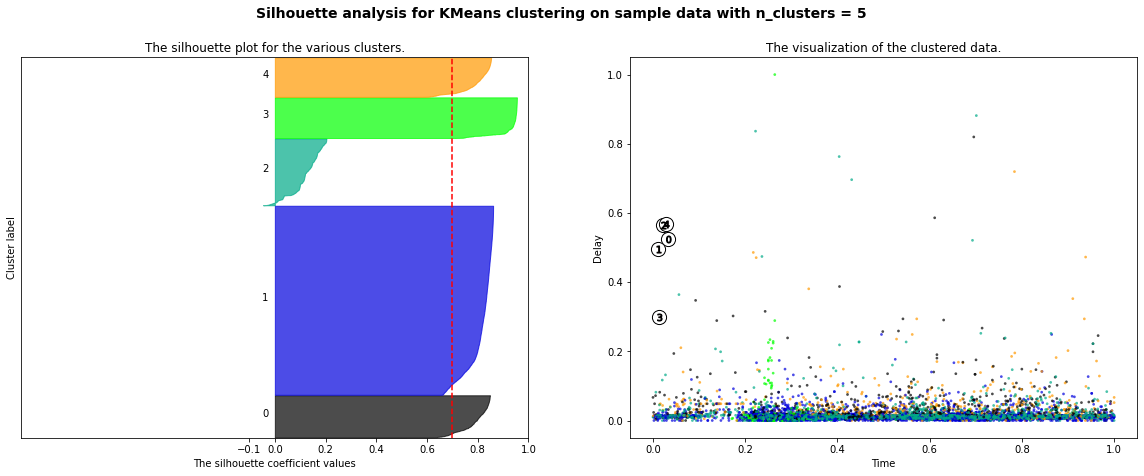

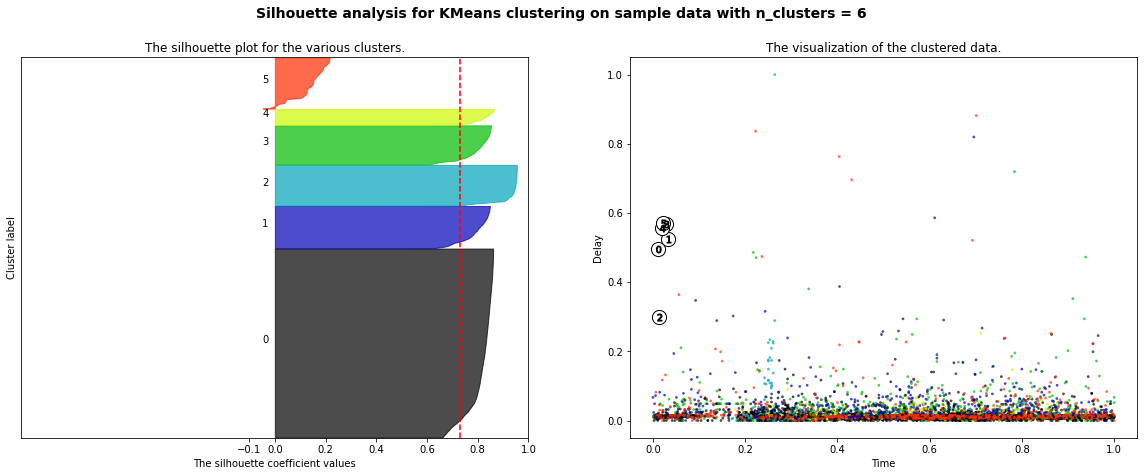

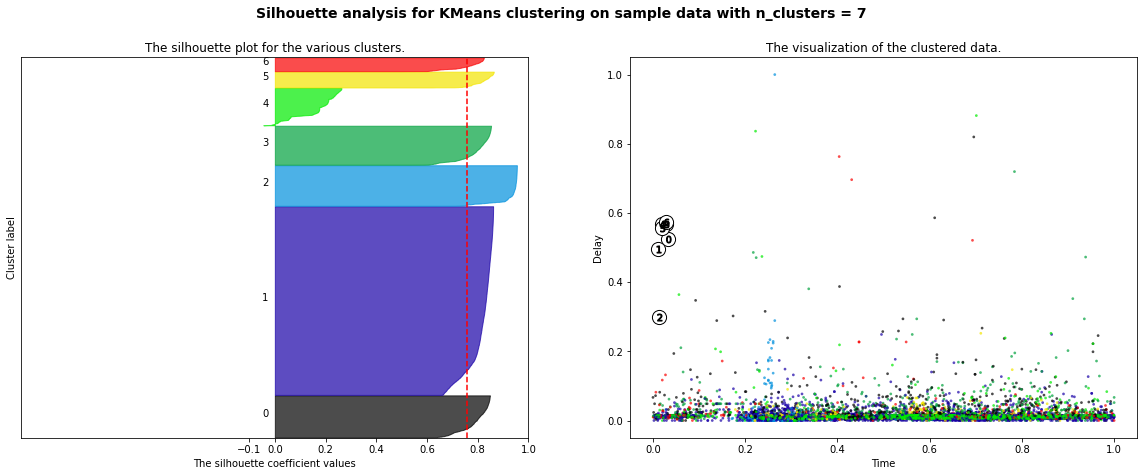

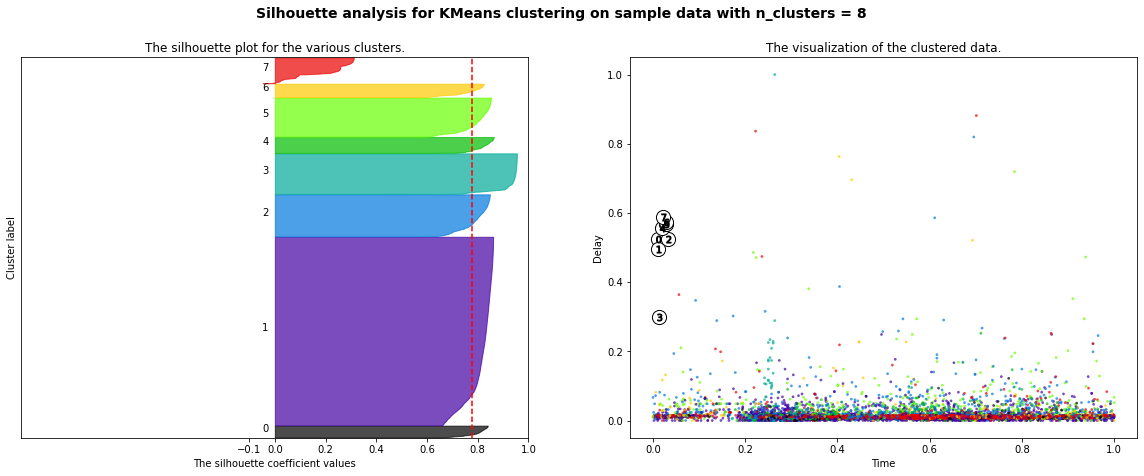

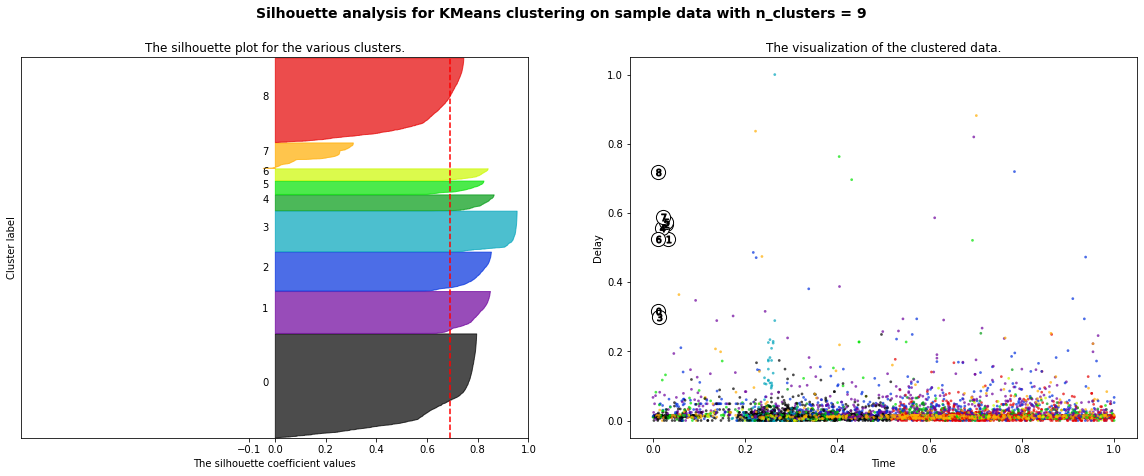

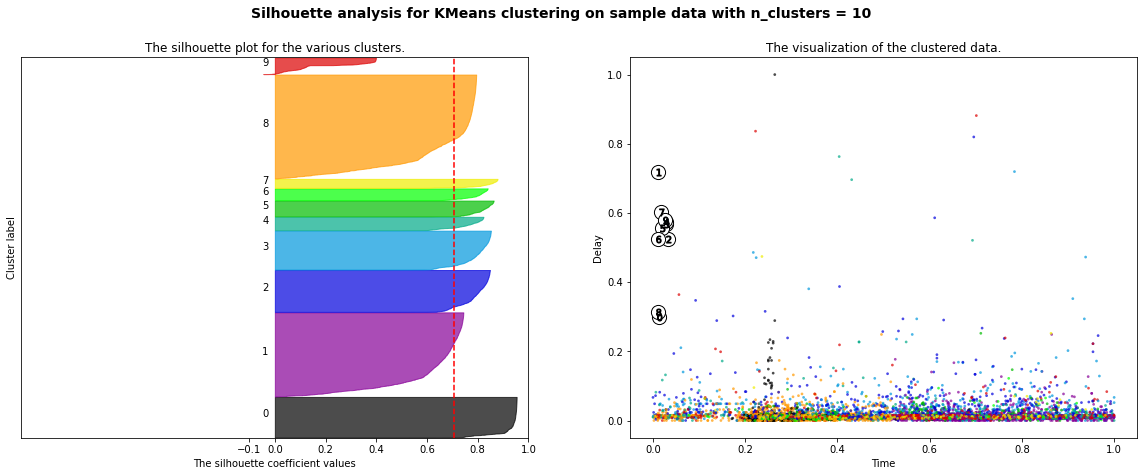

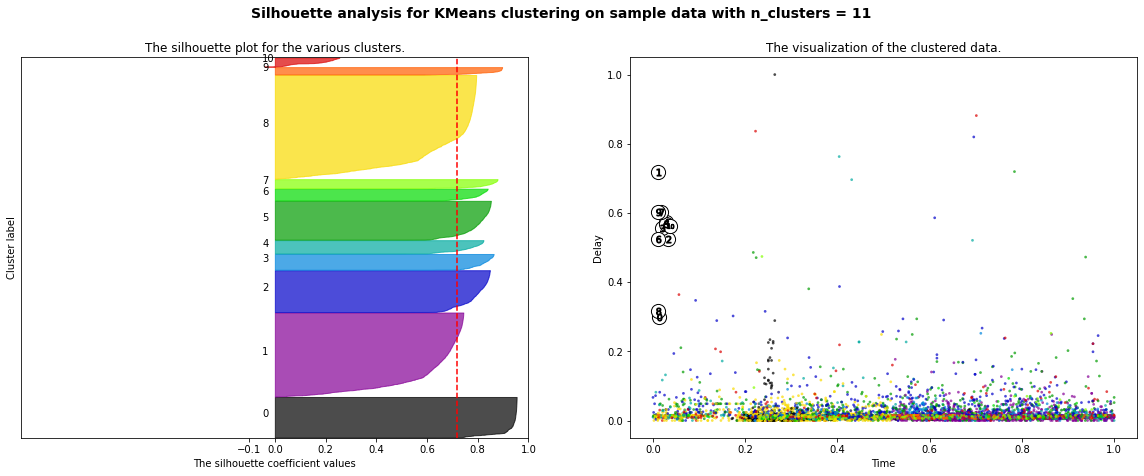

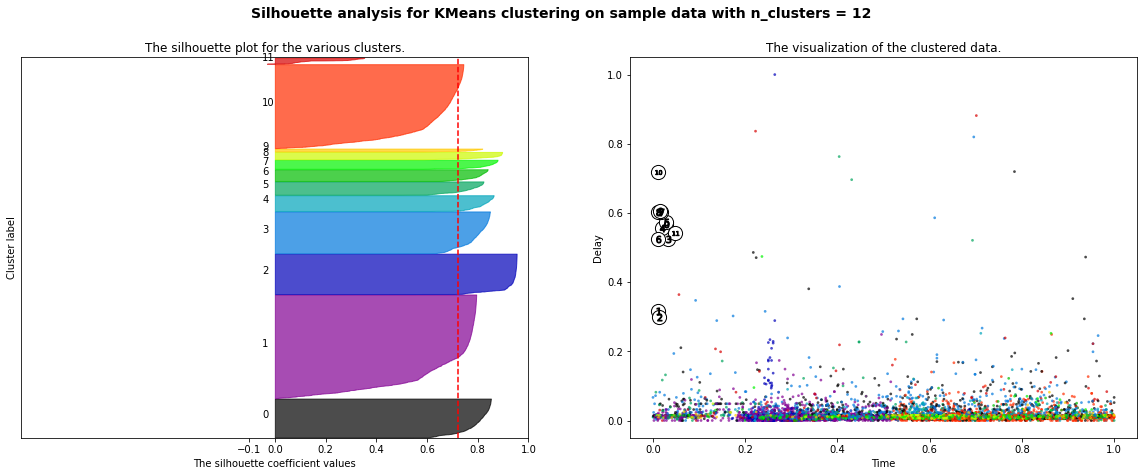

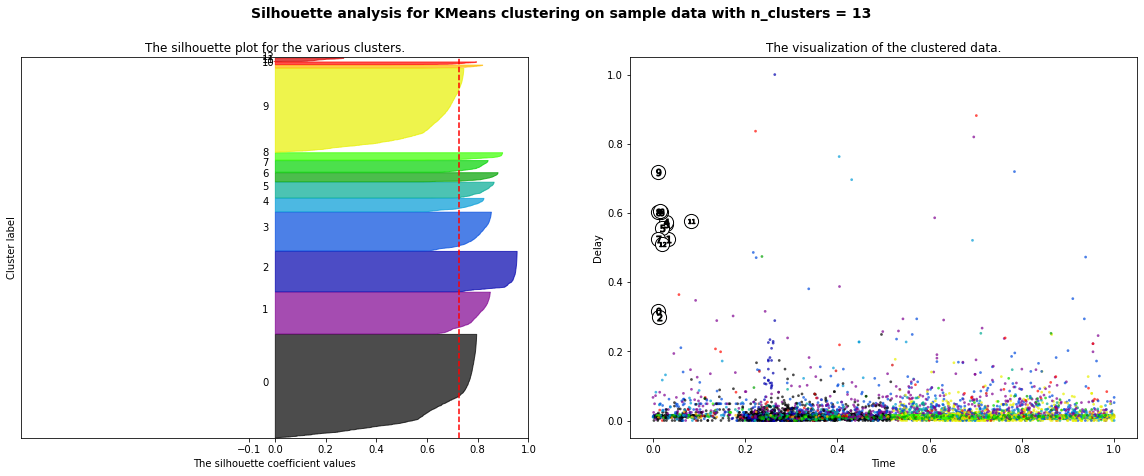

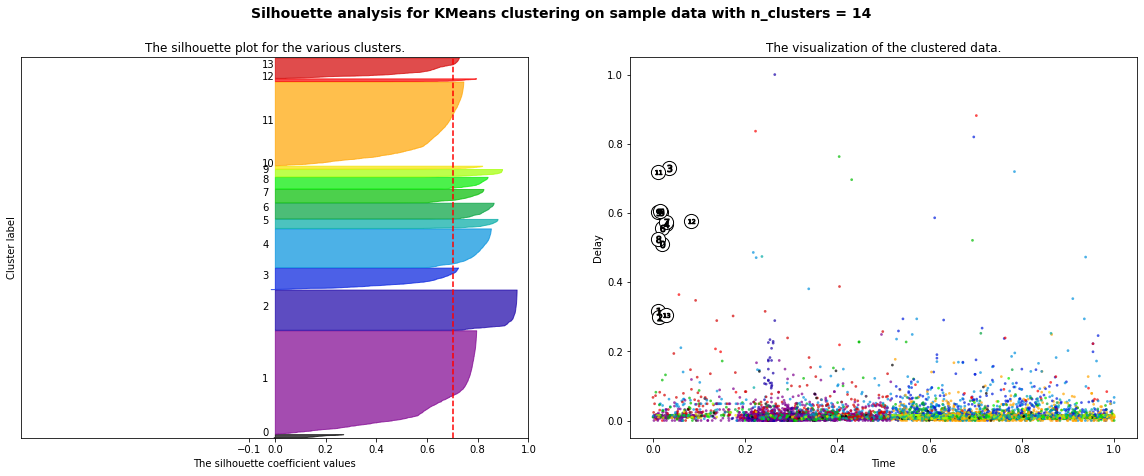

In [123]:
X, y = incident_dummy['Time_in_hours'], incident_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(incident_dummy)
    cluster_labels = clusterer.predict(incident_dummy)
    
    silhouette_avg = silhouette_score(incident_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(incident_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        incident_dummy['Time_in_hours'], incident_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Delay")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

## K-Means (day, location, incident as dummy variable)

In [92]:
DLI_data = df.drop(['Report_Date', 'Min_Delay', 'Direction',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time'], axis=1)
DLI_data

Day                        Location             Incident
0     Thursday         dundas_and_roncesvalles  late_leaving_garage
1     Thursday                   king_and_shaw   utilized_off_route
2     Thursday       kingston_road_and_bingham              held_by
3     Thursday  king_st._and_roncesvalles_ave.        investigation
4     Thursday               king_and_bathurst   utilized_off_route
...        ...                             ...                  ...
1012    Sunday                     gunn's_loop           mechanical
1013    Sunday             queen_and_broadview   emergency_services
1014    Sunday                king_and_spadina           mechanical
1016    Sunday                queen_and_church              held_by
1017    Sunday             spadina_and_college             cleaning

[8744 rows x 3 columns]

In [93]:
#encoded df
DLI_dummy = df

for i in DLI_data:
    dummies = pd.get_dummies(DLI_data[i])
    DLI_dummy = pd.concat([DLI_dummy, dummies], axis=1)
    DLI_dummy = DLI_dummy.drop(i, axis=1)

DLI_dummy = DLI_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route','Direction'], axis=1)

DLI_dummy['Min_Delay'] = (DLI_dummy['Min_Delay'] - DLI_dummy['Min_Delay'].min()) / (DLI_dummy['Min_Delay'].max() - DLI_dummy['Min_Delay'].min())
DLI_dummy['Time_in_hours'] = (DLI_dummy['Time_in_hours'] - DLI_dummy['Time_in_hours'].min()) / (DLI_dummy['Time_in_hours'].max() - DLI_dummy['Time_in_hours'].min())

DLI_dummy


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0      0.005008       0.271716       0       0         0       0         1   
1      0.031720       0.530229       0       0         0       0         1   
2      0.020033       0.584434       0       0         0       0         1   
3      0.010017       0.599027       0       0         0       0         1   
4      0.003339       0.696317       0       0         0       0         1   
...         ...            ...     ...     ...       ...     ...       ...   
1012   0.006678       0.924253       0       0         0       1         0   
1013   0.016694       0.947186       0       0         0       1         0   
1014   0.003339       0.010424       0       0         0       1         0   
1016   0.020033       0.031967       0       0         0       1         0   
1017   0.018364       0.057679       0       0         0       1         0   

      Tuesday  Wednesday  1st_and_lakeshore  ...  investigation  late  \
0           0          0                  0  ...              0     0   
1           0          0                  0  ...              0     0   
2           0          0                  0  ...              0     0   
3           0          0                  0  ...              1     0   
4           0          0                  0  ...              0     0   
...       ...        ...                ...  ...            ...   ...   
1012        0          0                  0  ...              0     0   
1013        0          0                  0  ...              0     0   
1014        0          0                  0  ...              0     0   
1016        0          0                  0  ...              0     0   
1017        0          0                  0  ...              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
0                       1           0           0         0   
1                       0           0           0         0   
2                       0           0           0         0   
3                       0           0           0         0   
4                       0           0           0         0   
...                   ...         ...         ...       ...   
1012                    0           1           0         0   
1013                    0           0           0         0   
1014                    0           1           0         0   
1016                    0           0           0         0   
1017                    0           0           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
0                         0              0         0                   0  
1                         0              0         0                   1  
2                         0              0         0                   0  
3                         0              0         0                   0  
4                         0              0         0                   1  
...                     ...            ...       ...                 ...  
1012                      0              0         0                   0  
1013                      0              0         0                   0  
1014                      0              0         0                   0  
1016                      0              0         0                   0  
1017                      0              0         0                   0  

[8744 rows x 2827 columns]

In [94]:
# Try various values of k
sil_scores_DLI = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DLI_dummy)
    label = clusterer.predict(DLI_dummy)
    sil_scores_DLI.append({'k':k, 'silhouette_score':silhouette_score(DLI_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores_DLI = pd.DataFrame(sil_scores_DLI)
best_label_DLI = sil_scores_DLI.loc[sil_scores_DLI['silhouette_score'].idxmax(),'label'] 
best_label_DLI

# Present some summary statistics for each clusters
df.groupby(best_label_DLI).mean()

Min_Delay  Time_in_hours
0  10.807794      11.287043
1  11.062268      11.824388
2  10.689432      11.729176
3  12.054980      11.878048
4   9.773773      12.060008
5  12.557224      12.598248

In [98]:
df.groupby(best_label_DLI).describe()

Min_Delay                                                   Time_in_hours  \
      count       mean        std  min  25%  50%   75%    max         count   
0    1514.0  10.807794  24.510988  1.0  4.0  6.0  10.0  492.0        1514.0   
1    1349.0  11.062268  21.657654  1.0  5.0  6.0  10.0  418.0        1349.0   
2    1391.0  10.689432  17.574913  1.0  4.0  6.0  10.0  285.0        1391.0   
3    1255.0  12.054980  24.524948  1.0  5.0  6.0  10.0  600.0        1255.0   
4    1304.0   9.773773  12.874990  1.0  4.0  6.0  10.0  182.0        1304.0   
5    1931.0  12.557224  26.295416  1.0  6.0  8.0  10.0  529.0        1931.0   

                                                                             
        mean       std       min       25%        50%        75%        max  
0  11.287043  5.513108  0.000000  6.733333   9.683333  15.679167  23.983333  
1  11.824388  5.825807  0.050000  6.733333  11.183333  16.516667  23.983333  
2  11.729176  5.971358  0.000000  6.616667  11.083333  16.225000  23.983333  
3  11.878048  5.781947  0.083333  6.783333  11.550000  16.416667  23.966667  
4  12.060008  5.577925  0.100000  7.233333  11.250000  16.325000  23.966667  
5  12.598248  5.964327  0.016667  8.308333  12.650000  17.333333  23.983333

In [99]:
sil_scores_DLI

k  silhouette_score                                              label
0   5          0.126405  [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, ...
1   6          0.181846  [3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...
2   7          0.168843  [6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, ...
3   8          0.160883  [5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, ...
4   9          0.161615  [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, ...
5  10          0.158759  [3, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, ...
6  11          0.154005  [5, 10, 2, 9, 10, 2, 10, 9, 7, 1, 1, 1, 1, 1, ...
7  12          0.160038  [1, 9, 8, 3, 9, 8, 9, 3, 11, 11, 11, 11, 11, 1...
8  13          0.169400  [2, 8, 8, 8, 8, 8, 8, 8, 9, 3, 3, 3, 3, 3, 3, ...
9  14          0.165209  [2, 12, 12, 12, 12, 12, 12, 12, 4, 4, 4, 4, 4,...

For k = 5 The average silhouette_score is : 0.12660853440201011
For k = 6 The average silhouette_score is : 0.13897241219025924
For k = 7 The average silhouette_score is : 0.14202495717739008
For k = 8 The average silhouette_score is : 0.1862110562714342
For k = 9 The average silhouette_score is : 0.17973168069178339
For k = 10 The average silhouette_score is : 0.16320277817660306
For k = 11 The average silhouette_score is : 0.15549913952220726
For k = 12 The average silhouette_score is : 0.16518465221047157
For k = 13 The average silhouette_score is : 0.16271095241292272
For k = 14 The average silhouette_score is : 0.16415172200087833


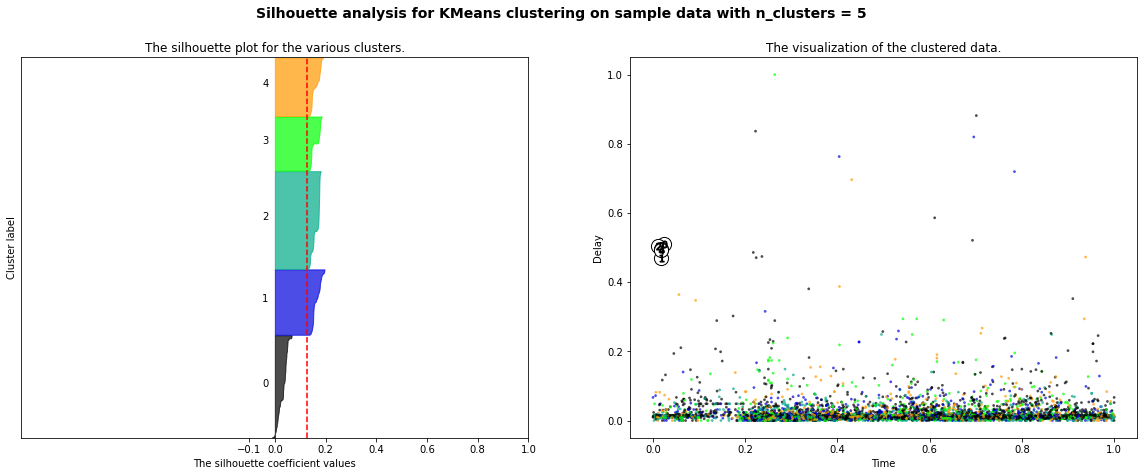

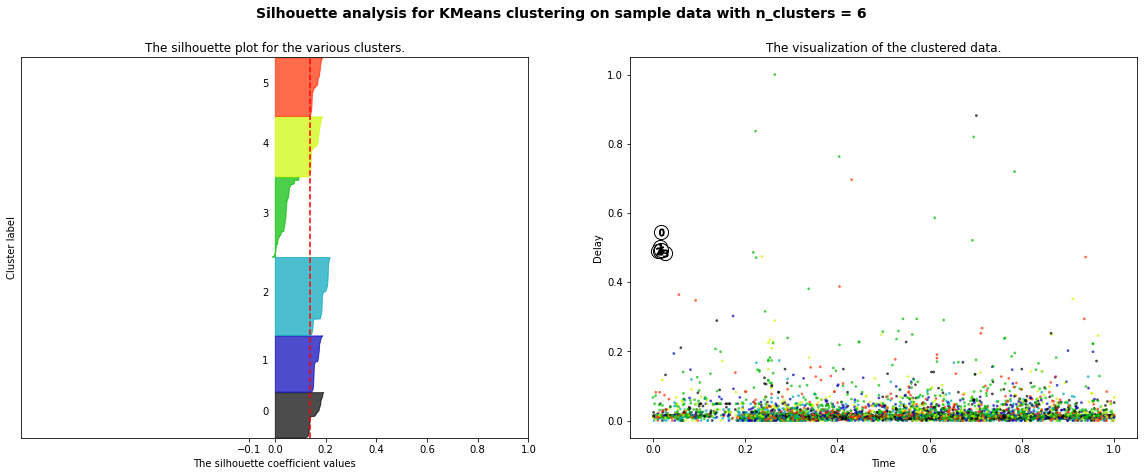

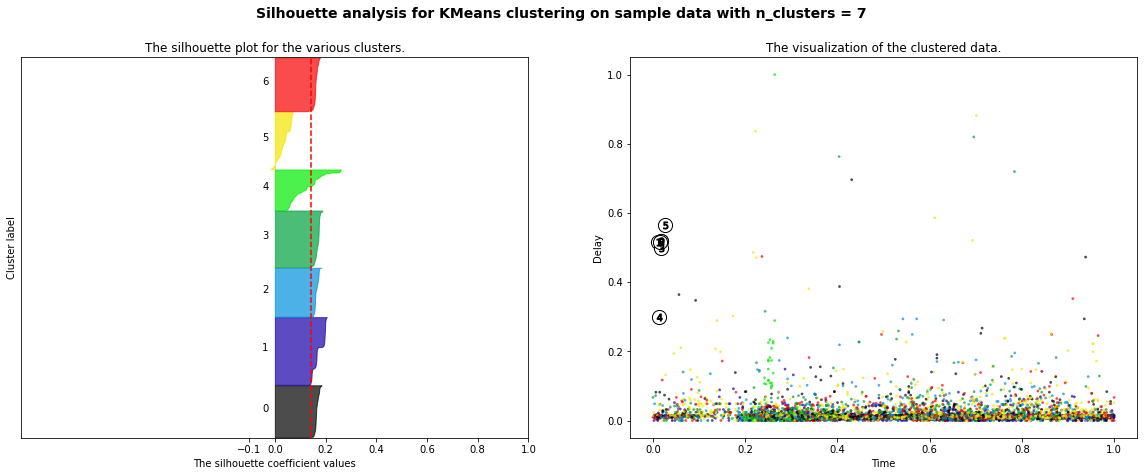

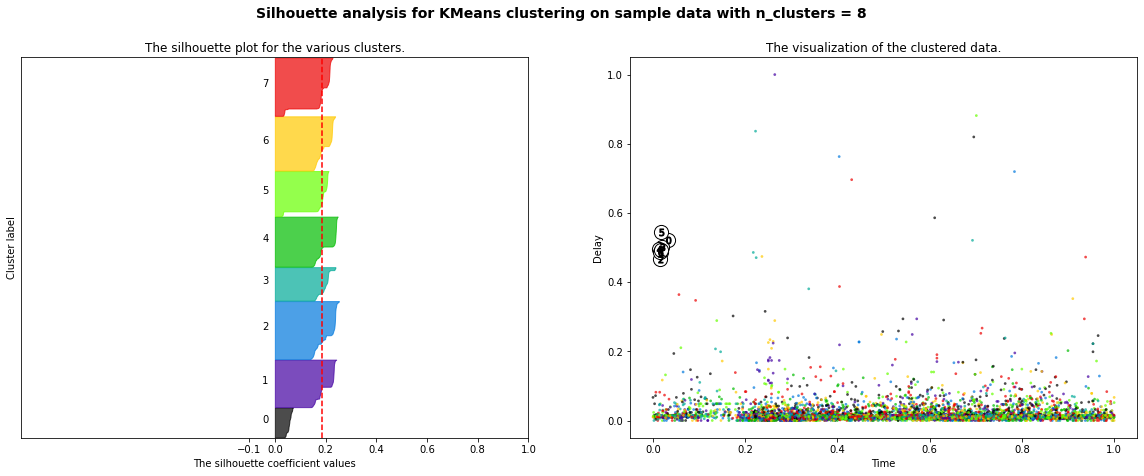

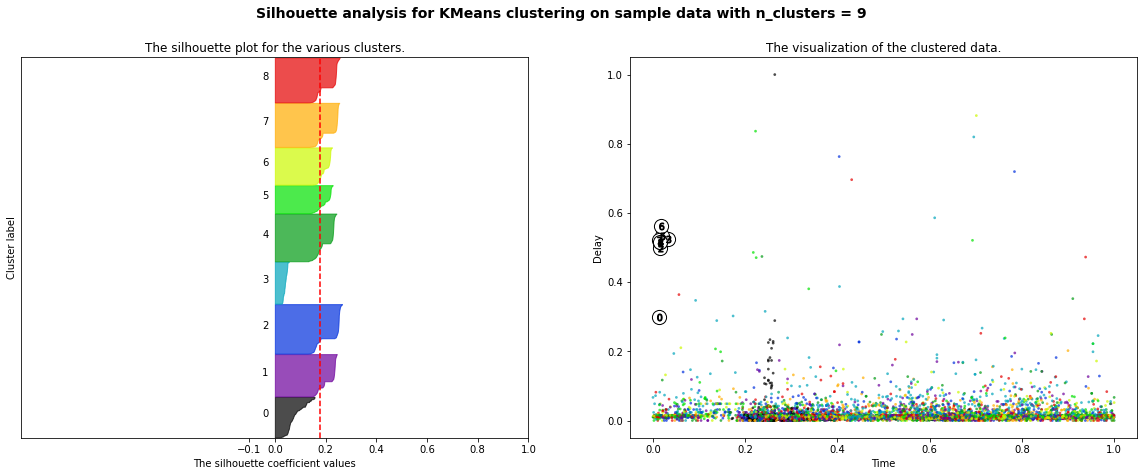

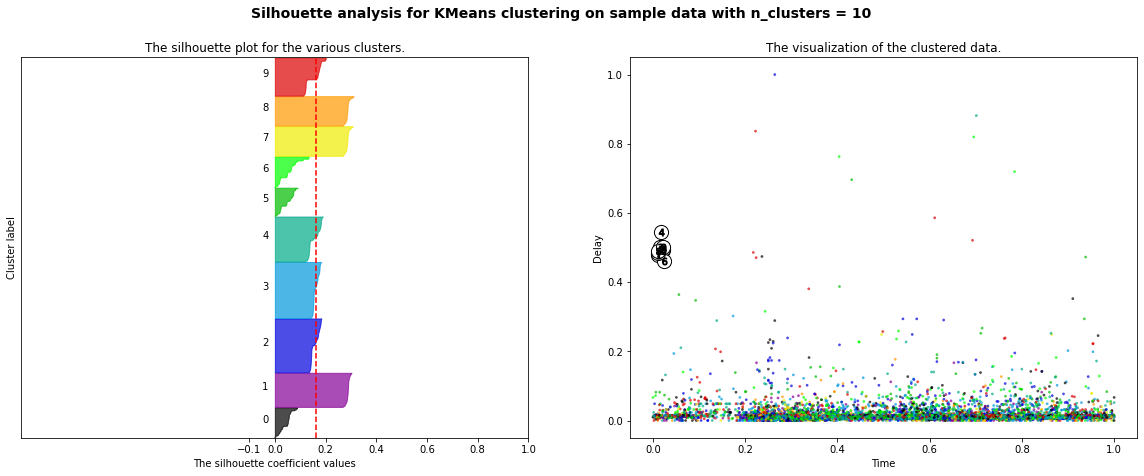

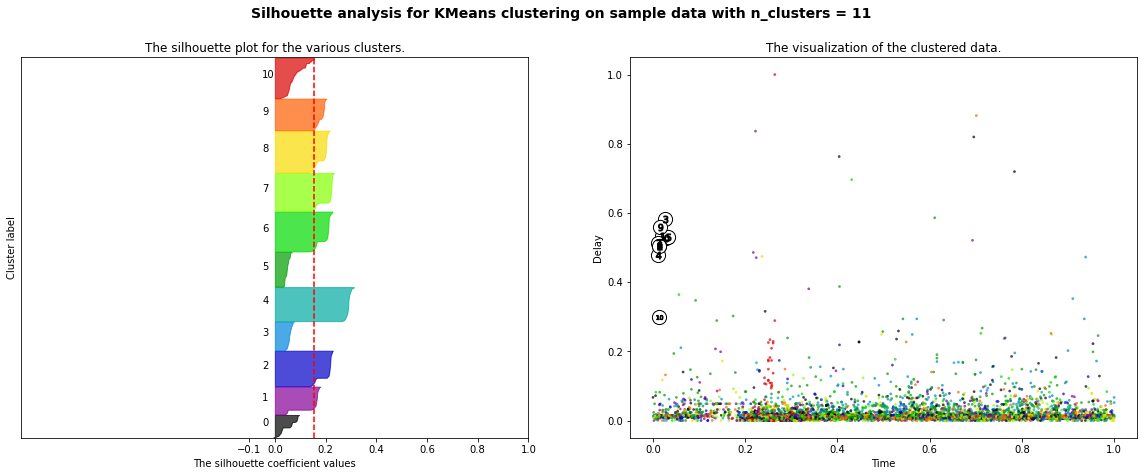

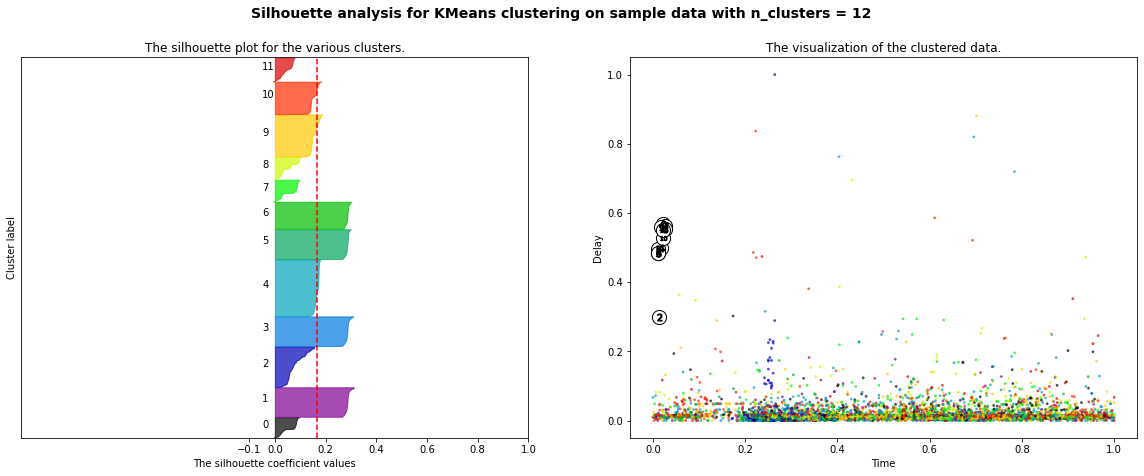

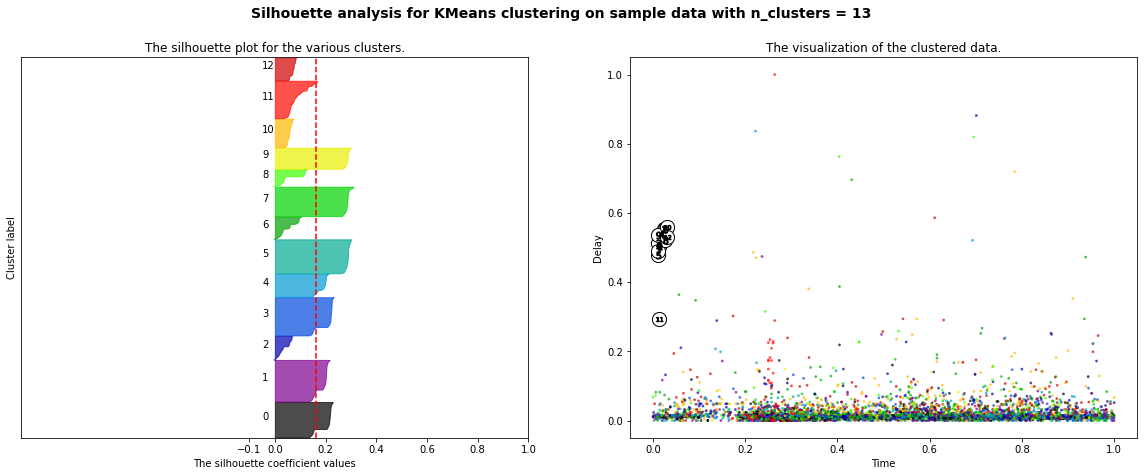

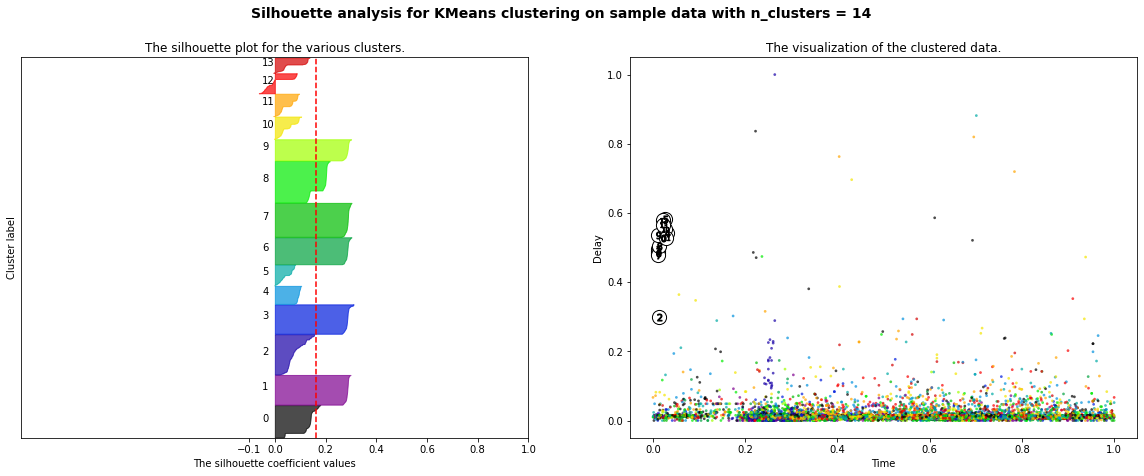

In [124]:
X, y = DLI_dummy['Time_in_hours'], DLI_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DLI_dummy)
    cluster_labels = clusterer.predict(DLI_dummy)
    
    silhouette_avg = silhouette_score(DLI_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(DLI_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        DLI_dummy['Time_in_hours'], DLI_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Delay")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

## K-Means (day and incident as dummy variable)

In [104]:
DI_data = df.drop(['Report_Date', 'Min_Delay', 'Direction', 'Location',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time'], axis=1)
DI_data

Day             Incident
0     Thursday  late_leaving_garage
1     Thursday   utilized_off_route
2     Thursday              held_by
3     Thursday        investigation
4     Thursday   utilized_off_route
...        ...                  ...
1012    Sunday           mechanical
1013    Sunday   emergency_services
1014    Sunday           mechanical
1016    Sunday              held_by
1017    Sunday             cleaning

[8744 rows x 2 columns]

In [105]:
#encoded df
DI_dummy = df

for i in DI_data:
    dummies = pd.get_dummies(DI_data[i])
    DI_dummy = pd.concat([DI_dummy, dummies], axis=1)
    DI_dummy = DI_dummy.drop(i, axis=1)

DI_dummy = DI_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Direction', 'Location'], axis=1)

DI_dummy['Min_Delay'] = (DI_dummy['Min_Delay'] - DI_dummy['Min_Delay'].min()) / (DI_dummy['Min_Delay'].max() - DI_dummy['Min_Delay'].min())
DI_dummy['Time_in_hours'] = (DI_dummy['Time_in_hours'] - DI_dummy['Time_in_hours'].min()) / (DI_dummy['Time_in_hours'].max() - DI_dummy['Time_in_hours'].min())

DI_dummy


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0      0.005008       0.271716       0       0         0       0         1   
1      0.031720       0.530229       0       0         0       0         1   
2      0.020033       0.584434       0       0         0       0         1   
3      0.010017       0.599027       0       0         0       0         1   
4      0.003339       0.696317       0       0         0       0         1   
...         ...            ...     ...     ...       ...     ...       ...   
1012   0.006678       0.924253       0       0         0       1         0   
1013   0.016694       0.947186       0       0         0       1         0   
1014   0.003339       0.010424       0       0         0       1         0   
1016   0.020033       0.031967       0       0         0       1         0   
1017   0.018364       0.057679       0       0         0       1         0   

      Tuesday  Wednesday  cleaning  ...  investigation  late  \
0           0          0         0  ...              0     0   
1           0          0         0  ...              0     0   
2           0          0         0  ...              0     0   
3           0          0         0  ...              1     0   
4           0          0         0  ...              0     0   
...       ...        ...       ...  ...            ...   ...   
1012        0          0         0  ...              0     0   
1013        0          0         0  ...              0     0   
1014        0          0         0  ...              0     0   
1016        0          0         0  ...              0     0   
1017        0          0         1  ...              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
0                       1           0           0         0   
1                       0           0           0         0   
2                       0           0           0         0   
3                       0           0           0         0   
4                       0           0           0         0   
...                   ...         ...         ...       ...   
1012                    0           1           0         0   
1013                    0           0           0         0   
1014                    0           1           0         0   
1016                    0           0           0         0   
1017                    0           0           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
0                         0              0         0                   0  
1                         0              0         0                   1  
2                         0              0         0                   0  
3                         0              0         0                   0  
4                         0              0         0                   1  
...                     ...            ...       ...                 ...  
1012                      0              0         0                   0  
1013                      0              0         0                   0  
1014                      0              0         0                   0  
1016                      0              0         0                   0  
1017                      0              0         0                   0  

[8744 rows x 25 columns]

In [107]:
# Try various values of k
sil_scores_DI = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DI_dummy)
    label = clusterer.predict(DI_dummy)
    sil_scores_DI.append({'k':k, 'silhouette_score':silhouette_score(DI_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores_DI = pd.DataFrame(sil_scores_DI)
best_label_DI = sil_scores_DI.loc[sil_scores_DI['silhouette_score'].idxmax(),'label'] 
best_label_DI

# Present some summary statistics for each clusters
df.groupby(best_label_DI).mean()

Min_Delay  Time_in_hours
0   16.053608      13.981890
1    7.933333      12.881481
2   16.263889      13.487103
3    7.476879      11.641137
4    7.639535      11.759181
5    7.713154      11.634918
6    7.280856      11.468640
7   17.365805      11.676176
8    8.073684      12.427719
9   10.200686      12.595826
10   8.906634       7.005938
11  18.032505      12.630433
12  17.049904      13.283429
13  14.649635      13.239082

In [108]:
df.groupby(best_label_DI).describe()

Min_Delay                                                   Time_in_hours  \
       count       mean        std  min  25%  50%   75%    max         count   
0      485.0  16.053608  29.942528  1.0  6.0  8.0  16.0  529.0         485.0   
1      495.0   7.933333   8.039981  1.0  5.0  6.0   8.0   90.0         495.0   
2      504.0  16.263889  22.903198  1.0  6.0  8.0  18.0  177.0         504.0   
3      692.0   7.476879   9.872166  1.0  4.0  5.0   7.0  150.0         692.0   
4      688.0   7.639535   8.533742  1.0  4.0  5.0   8.0  107.0         688.0   
5      631.0   7.713154   8.850709  1.0  4.0  6.0   8.0  105.0         631.0   
6      794.0   7.280856   7.964325  1.0  4.0  5.0   7.0  101.0         794.0   
7      503.0  17.365805  40.000465  1.0  6.0  8.0  12.0  502.0         503.0   
8      380.0   8.073684   5.779122  1.0  5.0  7.0   9.0   46.0         380.0   
9     1166.0  10.200686  13.446924  1.0  5.0  6.0  10.0  182.0        1166.0   
10     814.0   8.906634  26.159293  1.0  4.0  5.0   7.0  600.0         814.0   
11     523.0  18.032505  39.502860  1.0  6.0  9.0  17.0  492.0         523.0   
12     521.0  17.049904  32.536568  1.0  6.0  8.0  15.0  418.0         521.0   
13     548.0  14.649635  21.101597  1.0  6.0  9.0  16.0  285.0         548.0   

                                                                               
         mean       std       min        25%        50%        75%        max  
0   13.981890  6.131627  0.016667  10.116667  14.416667  18.950000  23.983333  
1   12.881481  5.380203  0.116667   9.141667  12.733333  16.525000  23.983333  
2   13.487103  5.940012  0.083333   9.000000  14.166667  17.991667  23.966667  
3   11.641137  5.742917  0.050000   6.816667  10.508333  16.083333  23.966667  
4   11.759181  5.693339  0.050000   7.066667  10.850000  16.254167  23.916667  
5   11.634918  5.489669  0.666667   6.958333  10.950000  16.000000  23.333333  
6   11.468640  5.335973  0.366667   6.916667  10.183333  15.695833  23.983333  
7   11.676176  6.397839  0.166667   6.500000  10.233333  17.383333  23.900000  
8   12.427719  5.752995  0.050000   8.429167  12.266667  16.525000  23.950000  
9   12.595826  5.552894  0.100000   7.883333  12.225000  17.016667  23.966667  
10   7.005938  2.488477  0.666667   5.733333   6.166667   7.050000  17.016667  
11  12.630433  5.807588  0.000000   7.925000  12.866667  17.508333  23.800000  
12  13.283429  5.871189  0.150000   8.500000  13.700000  18.383333  23.983333  
13  13.239082  6.198176  0.000000   8.550000  13.825000  18.283333  23.983333

In [109]:
sil_scores_DI

k  silhouette_score                                              label
0   5          0.258066  [4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, ...
1   6          0.339208  [4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, ...
2   7          0.407083  [2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, ...
3   8          0.401278  [1, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, ...
4   9          0.393673  [7, 4, 8, 4, 4, 8, 4, 4, 1, 1, 1, 1, 1, 1, 1, ...
5  10          0.403586  [1, 3, 2, 7, 3, 2, 3, 7, 0, 0, 0, 0, 0, 0, 0, ...
6  11          0.407698  [10, 3, 1, 2, 3, 1, 3, 2, 4, 4, 4, 4, 4, 4, 4,...
7  12          0.429781  [4, 11, 11, 11, 11, 11, 11, 11, 1, 5, 5, 5, 5,...
8  13          0.440721  [0, 7, 12, 10, 7, 12, 7, 10, 3, 6, 6, 6, 6, 6,...
9  14          0.465574  [10, 2, 2, 2, 2, 2, 2, 2, 13, 3, 3, 3, 3, 3, 3...

For k = 5 The average silhouette_score is : 0.2680820830339965
For k = 6 The average silhouette_score is : 0.3585666738542215
For k = 7 The average silhouette_score is : 0.336343350914939
For k = 8 The average silhouette_score is : 0.372408971747643
For k = 9 The average silhouette_score is : 0.39176115347434015
For k = 10 The average silhouette_score is : 0.40630166372460536
For k = 11 The average silhouette_score is : 0.4094301122834331
For k = 12 The average silhouette_score is : 0.4270618741920464
For k = 13 The average silhouette_score is : 0.4522236130772995
For k = 14 The average silhouette_score is : 0.4643792622525243


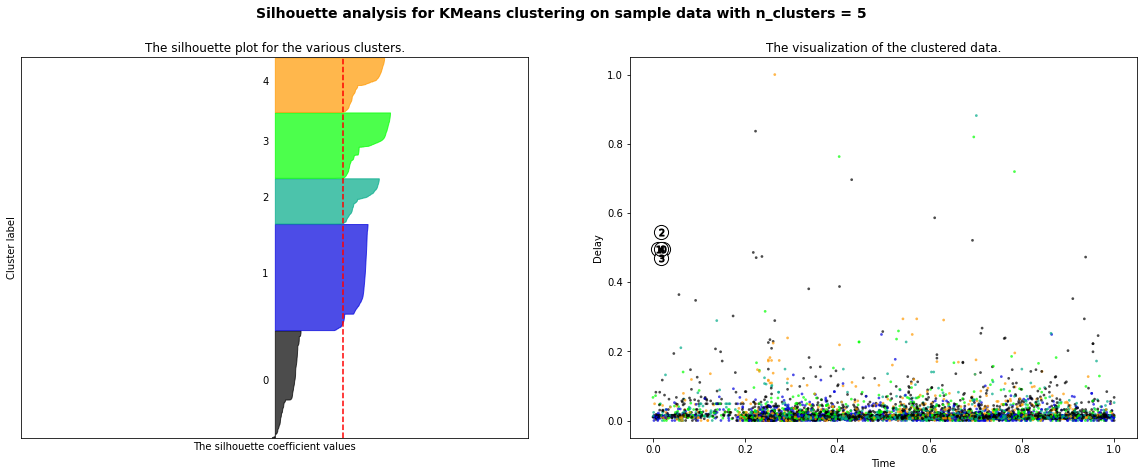

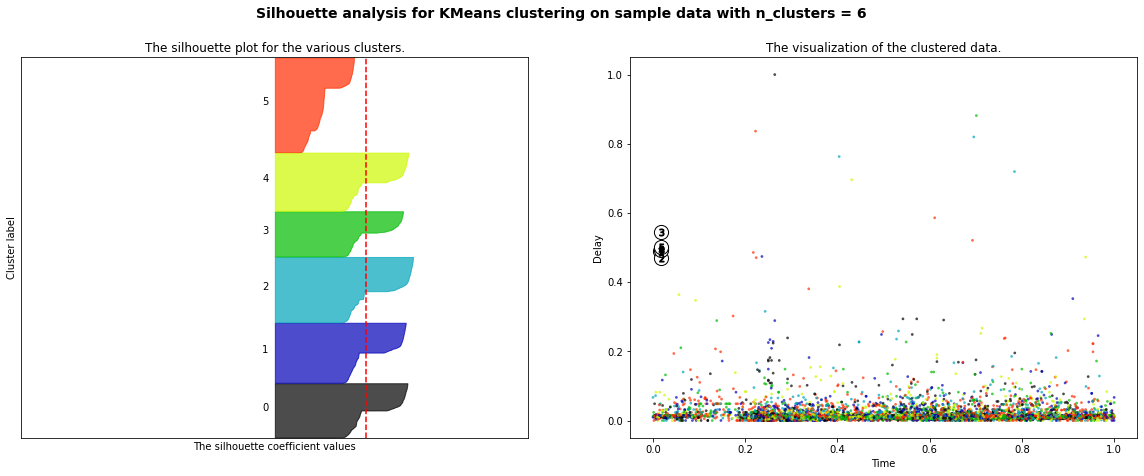

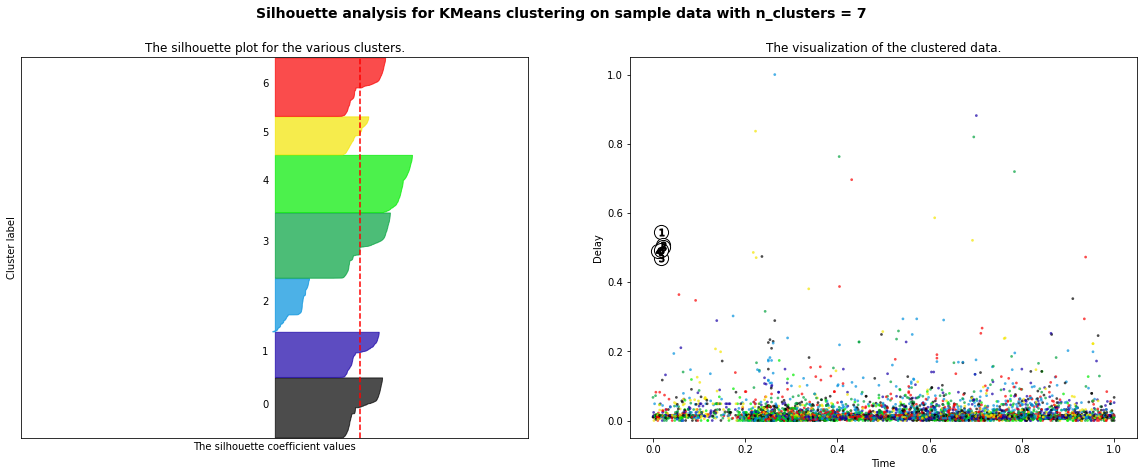

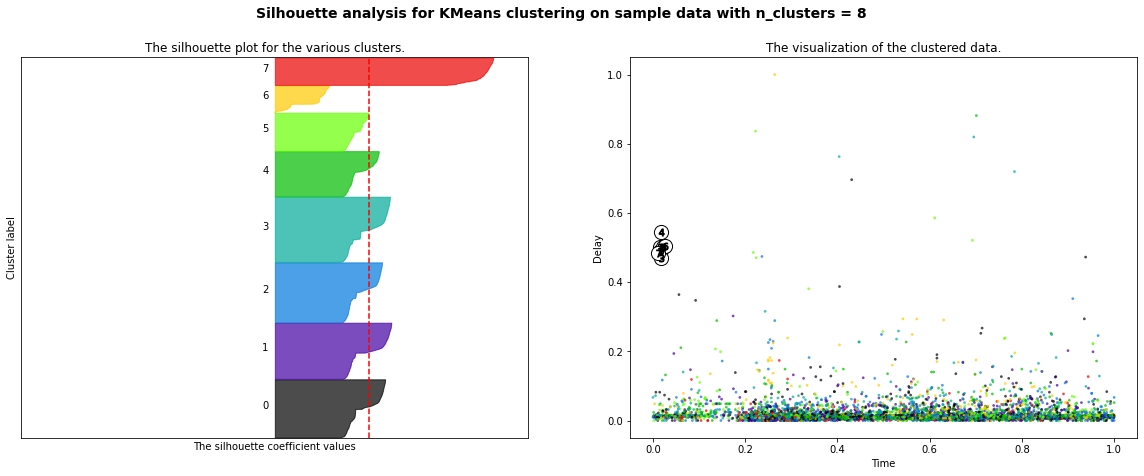

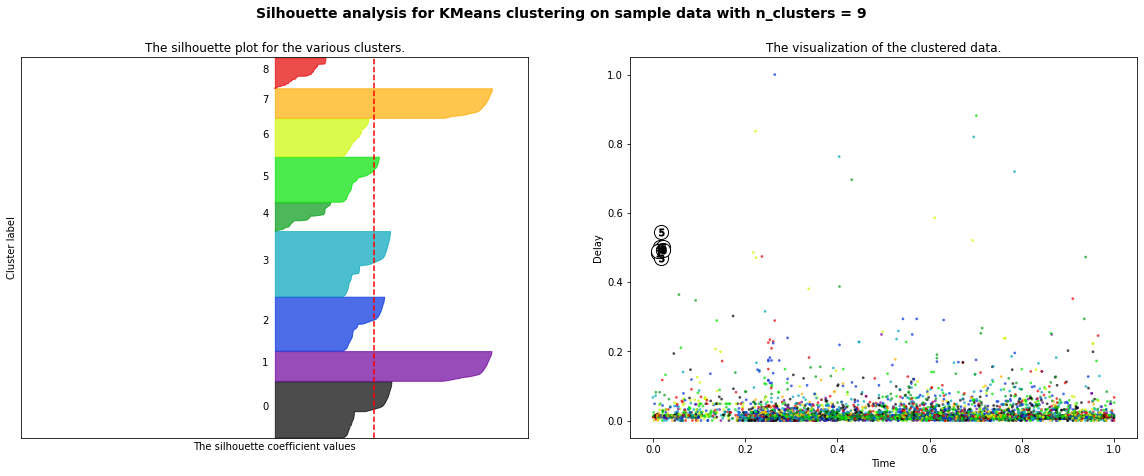

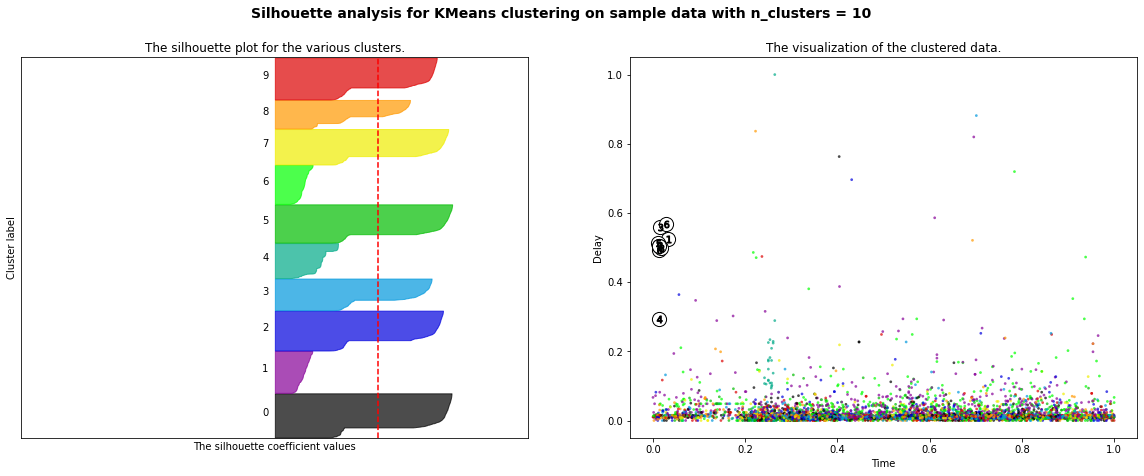

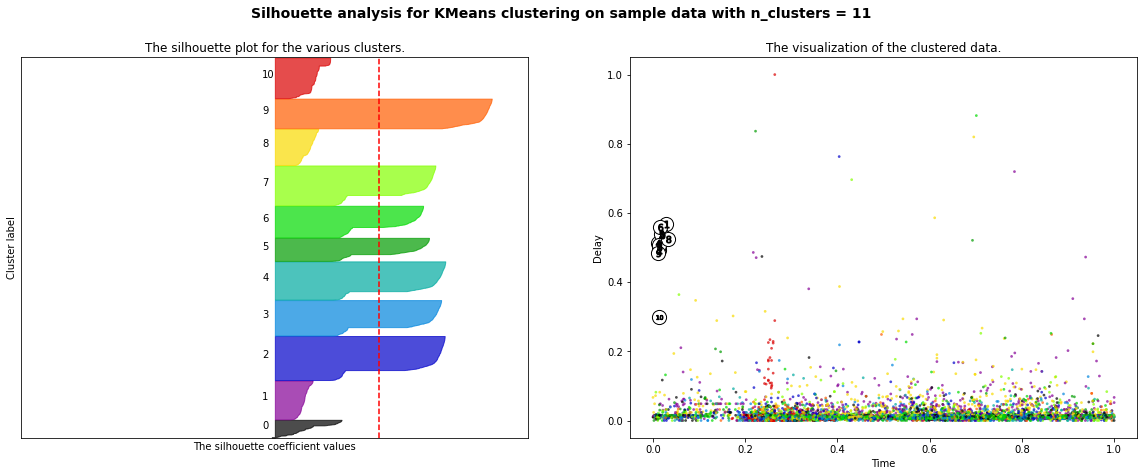

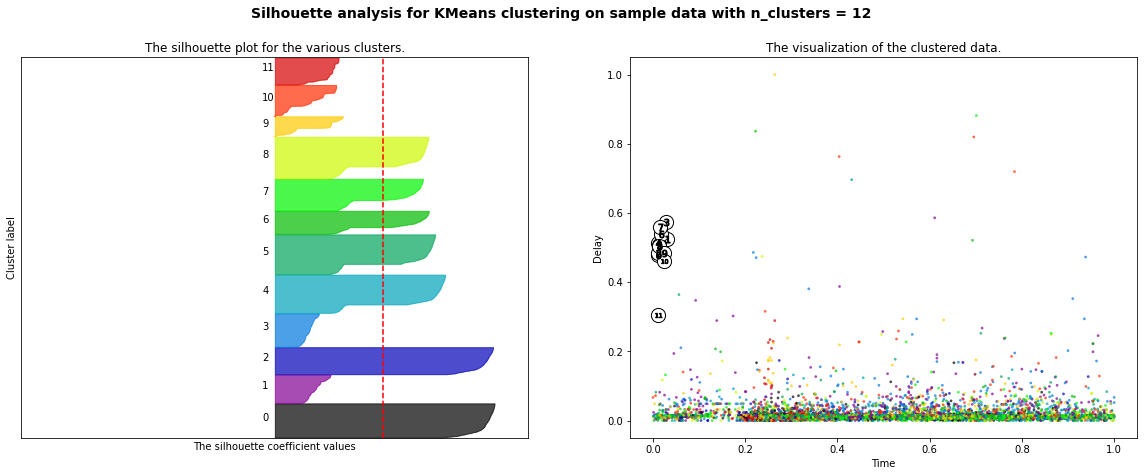

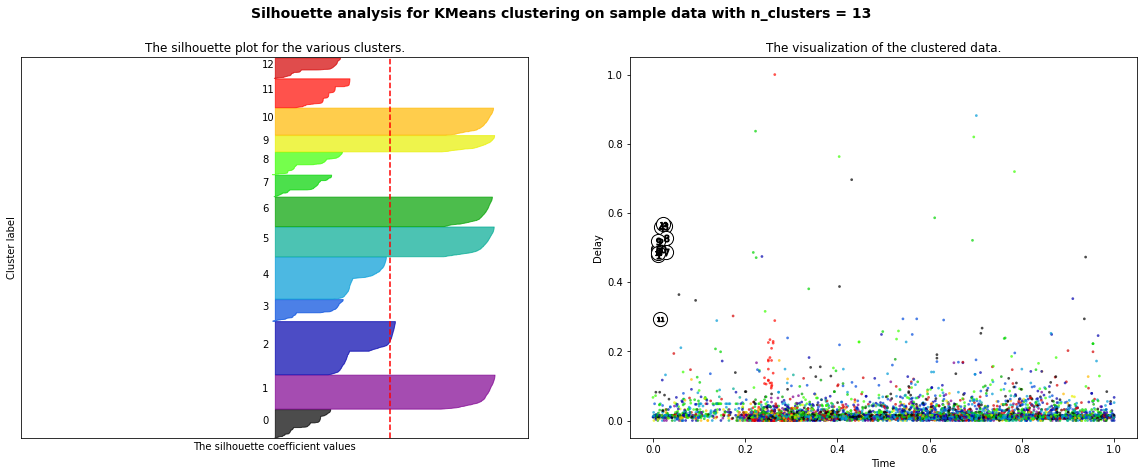

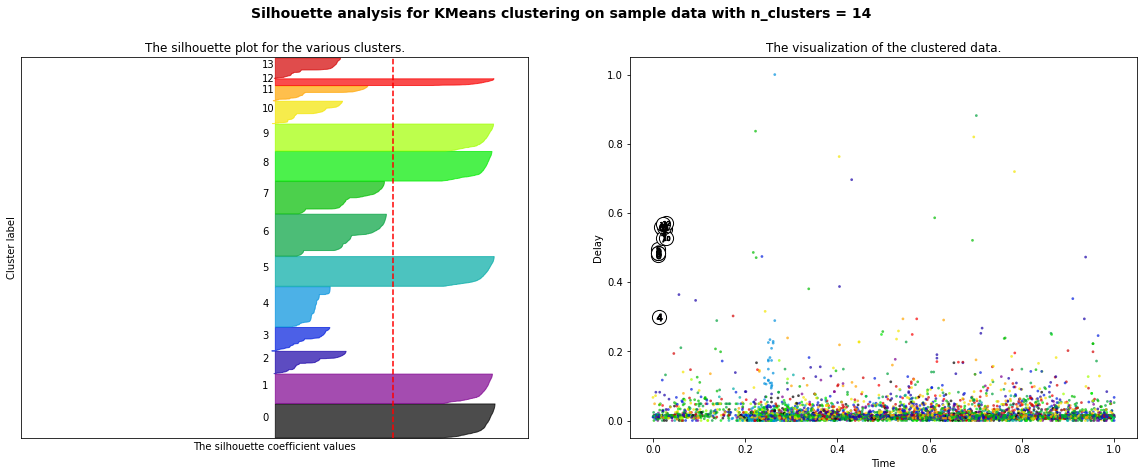

In [125]:
X, y = DI_dummy['Time_in_hours'], DI_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DI_dummy)
    cluster_labels = clusterer.predict(DI_dummy)
    
    silhouette_avg = silhouette_score(DI_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(DI_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        DI_dummy['Time_in_hours'],DI_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Delay")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

## K-Means (incident, location dummy variable)

In [113]:
IL_data = df.drop(['Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time'], axis=1)
IL_data

Location             Incident
0            dundas_and_roncesvalles  late_leaving_garage
1                      king_and_shaw   utilized_off_route
2          kingston_road_and_bingham              held_by
3     king_st._and_roncesvalles_ave.        investigation
4                  king_and_bathurst   utilized_off_route
...                              ...                  ...
1012                     gunn's_loop           mechanical
1013             queen_and_broadview   emergency_services
1014                king_and_spadina           mechanical
1016                queen_and_church              held_by
1017             spadina_and_college             cleaning

[8744 rows x 2 columns]

In [114]:
#encoded df
IL_dummy = df

for i in IL_data:
    dummies = pd.get_dummies(IL_data[i])
    IL_dummy = pd.concat([IL_dummy, dummies], axis=1)
    IL_dummy = IL_dummy.drop(i, axis=1)

IL_dummy = IL_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route','Direction', 'Day'], axis=1)

IL_dummy['Min_Delay'] = (IL_dummy['Min_Delay'] - IL_dummy['Min_Delay'].min()) / (IL_dummy['Min_Delay'].max() - IL_dummy['Min_Delay'].min())
IL_dummy['Time_in_hours'] = (IL_dummy['Time_in_hours'] - IL_dummy['Time_in_hours'].min()) / (IL_dummy['Time_in_hours'].max() - IL_dummy['Time_in_hours'].min())

IL_dummy


Min_Delay  Time_in_hours  1st_and_lakeshore  28th_street_and_lakeshore  \
0      0.005008       0.271716                  0                          0   
1      0.031720       0.530229                  0                          0   
2      0.020033       0.584434                  0                          0   
3      0.010017       0.599027                  0                          0   
4      0.003339       0.696317                  0                          0   
...         ...            ...                ...                        ...   
1012   0.006678       0.924253                  0                          0   
1013   0.016694       0.947186                  0                          0   
1014   0.003339       0.010424                  0                          0   
1016   0.020033       0.031967                  0                          0   
1017   0.018364       0.057679                  0                          0   

      37th_/_lakeshore  37th_street_and_lakeshore  40th_/_lakeshore  \
0                    0                          0                 0   
1                    0                          0                 0   
2                    0                          0                 0   
3                    0                          0                 0   
4                    0                          0                 0   
...                ...                        ...               ...   
1012                 0                          0                 0   
1013                 0                          0                 0   
1014                 0                          0                 0   
1016                 0                          0                 0   
1017                 0                          0                 0   

      506_carlton  5th_/_lakeshore  5th_and_lakeshore  ...  investigation  \
0               0                0                  0  ...              0   
1               0                0                  0  ...              0   
2               0                0                  0  ...              0   
3               0                0                  0  ...              1   
4               0                0                  0  ...              0   
...           ...              ...                ...  ...            ...   
1012            0                0                  0  ...              0   
1013            0                0                  0  ...              0   
1014            0                0                  0  ...              0   
1016            0                0                  0  ...              0   
1017            0                0                  0  ...              0   

      late  late_leaving_garage  mechanical  operations  overhead  \
0        0                    1           0           0         0   
1        0                    0           0           0         0   
2        0                    0           0           0         0   
3        0                    0           0           0         0   
4        0                    0           0           0         0   
...    ...                  ...         ...         ...       ...   
1012     0                    0           1           0         0   
1013     0                    0           0           0         0   
1014     0                    0           1           0         0   
1016     0                    0           0           0         0   
1017     0                    0           0           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
0                         0              0         0                   0  
1                         0              0         0                   1  
2                         0              0         0                   0  
3                         0              0         0                   0  
4                         0              0         0           

In [115]:
# Try various values of k
sil_scores_IL = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(IL_dummy)
    label = clusterer.predict(IL_dummy)
    sil_scores_IL.append({'k':k, 'silhouette_score':silhouette_score(IL_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores_IL = pd.DataFrame(sil_scores_IL)
best_label_IL = sil_scores_IL.loc[sil_scores_IL['silhouette_score'].idxmax(),'label'] 
best_label_IL

# Present some summary statistics for each clusters
df.groupby(best_label_IL).mean()

Min_Delay  Time_in_hours
0  18.368653      13.627778
1   8.777070       7.148248
2  20.036923      12.565333
3   7.565029      11.880510
4   7.619048      12.573260
5  13.663892      13.814586
6  17.701923      13.776335

In [116]:
df.groupby(best_label_IL).describe()

Min_Delay                                                    Time_in_hours  \
      count       mean        std  min  25%   50%   75%    max         count   
0     906.0  18.368653  30.797913  1.0  6.0   9.0  20.0  432.0         906.0   
1     942.0   8.777070  24.347144  1.0  4.0   6.0   8.0  600.0         942.0   
2     975.0  20.036923  31.376672  1.0  7.0  11.0  20.5  492.0         975.0   
3    4375.0   7.565029   8.236158  1.0  4.0   6.0   8.0  150.0        4375.0   
4     273.0   7.619048   7.957234  1.0  4.0   6.0   8.0   74.0         273.0   
5     961.0  13.663892  29.522386  1.0  6.0   8.0  11.0  529.0         961.0   
6     312.0  17.701923  42.007245  1.0  6.0   9.0  15.0  458.0         312.0   

                                                                             
        mean       std       min       25%        50%        75%        max  
0  13.627778  5.974737  0.016667  9.441667  14.233333  18.466667  23.983333  
1   7.148248  2.483148  0.666667  5.750000   6.250000   7.266667  17.016667  
2  12.565333  6.032712  0.000000  7.750000  12.666667  17.450000  23.800000  
3  11.880510  5.559733  0.050000  7.166667  11.250000  16.108333  23.983333  
4  12.573260  6.187643  0.366667  7.250000  12.716667  18.100000  23.933333  
5  13.814586  5.593684  0.000000  9.400000  14.083333  18.233333  23.983333  
6  13.776335  7.093773  0.016667  8.958333  15.108333  19.525000  23.983333

In [117]:
sil_scores_IL

k  silhouette_score                                              label
0   5          0.245080  [3, 4, 0, 2, 4, 0, 4, 2, 4, 1, 1, 1, 1, 1, 1, ...
1   6          0.255695  [3, 0, 2, 4, 0, 2, 0, 4, 0, 1, 1, 1, 1, 1, 1, ...
2   7          0.263031  [1, 4, 2, 0, 4, 2, 4, 0, 4, 3, 3, 3, 3, 3, 3, ...
3   8          0.141419  [6, 4, 3, 2, 4, 3, 4, 2, 4, 7, 7, 7, 7, 7, 7, ...
4   9          0.149290  [0, 5, 6, 2, 5, 6, 5, 2, 5, 4, 4, 4, 4, 4, 4, ...
5  10          0.137405  [3, 8, 4, 1, 8, 4, 8, 1, 8, 0, 0, 0, 0, 0, 0, ...
6  11          0.157670  [2, 0, 3, 5, 0, 3, 0, 5, 0, 1, 1, 1, 1, 1, 1, ...
7  12          0.132259  [6, 4, 0, 5, 4, 0, 4, 5, 4, 11, 11, 11, 11, 11...
8  13          0.093263  [8, 7, 3, 2, 7, 3, 7, 2, 7, 0, 0, 0, 0, 0, 0, ...
9  14          0.127746  [2, 9, 11, 5, 9, 11, 9, 5, 9, 12, 12, 12, 12, ...

For k = 5 The average silhouette_score is : 0.24507973223917315
For k = 6 The average silhouette_score is : 0.2556945607343399
For k = 7 The average silhouette_score is : 0.13230127173596665
For k = 8 The average silhouette_score is : 0.2706555570437636
For k = 9 The average silhouette_score is : 0.14828316415874873
For k = 10 The average silhouette_score is : 0.15524129218533342
For k = 11 The average silhouette_score is : 0.14417815539389958
For k = 12 The average silhouette_score is : 0.14266768574049438
For k = 13 The average silhouette_score is : 0.13693054594530368
For k = 14 The average silhouette_score is : 0.1417383413190229
For k = 15 The average silhouette_score is : 0.12055493272684094
For k = 16 The average silhouette_score is : 0.1178951805597213
For k = 17 The average silhouette_score is : 0.1059714873534519
For k = 18 The average silhouette_score is : 0.10878687050956075
For k = 19 The average silhouette_score is : 0.13520053144272678


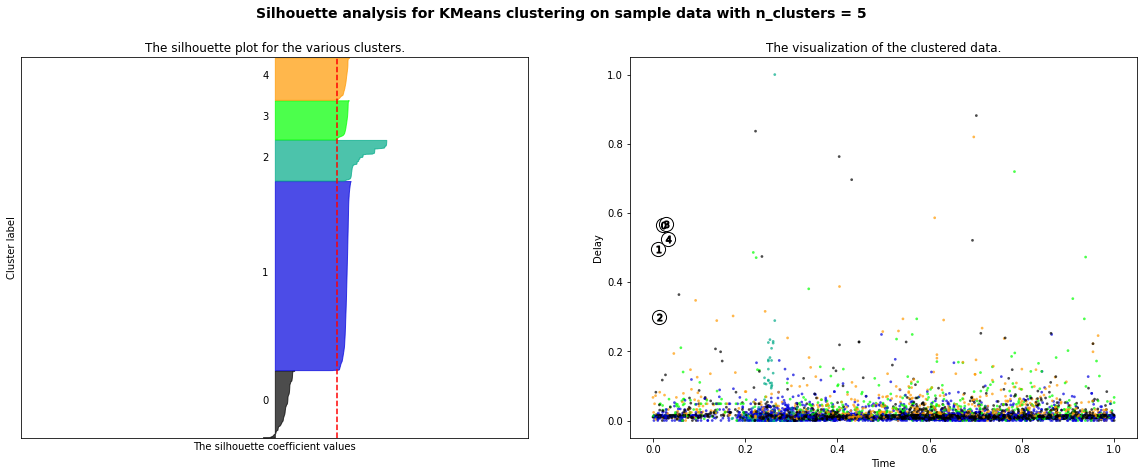

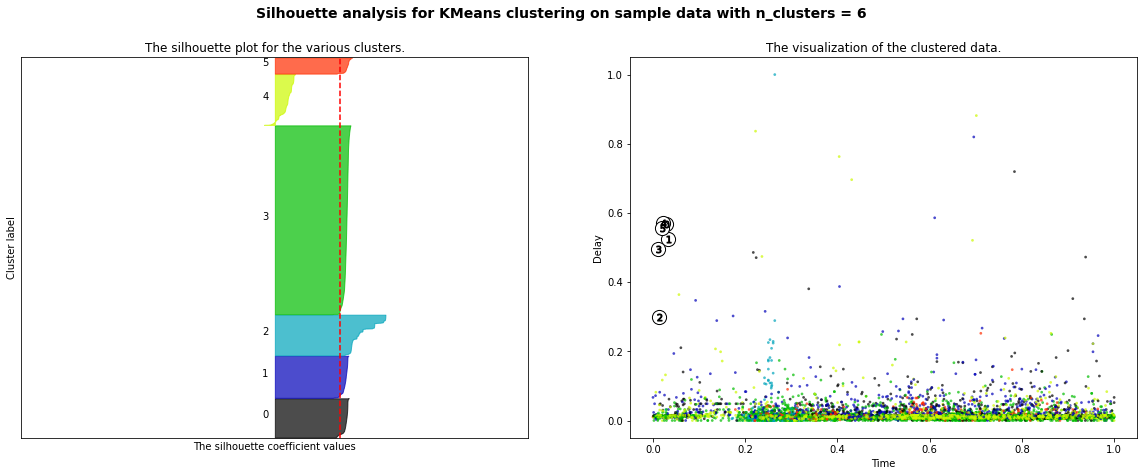

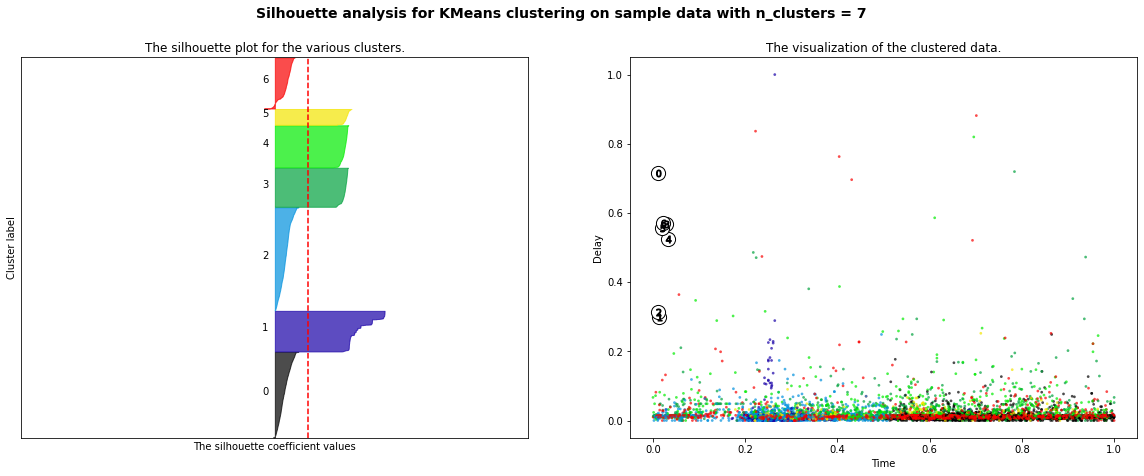

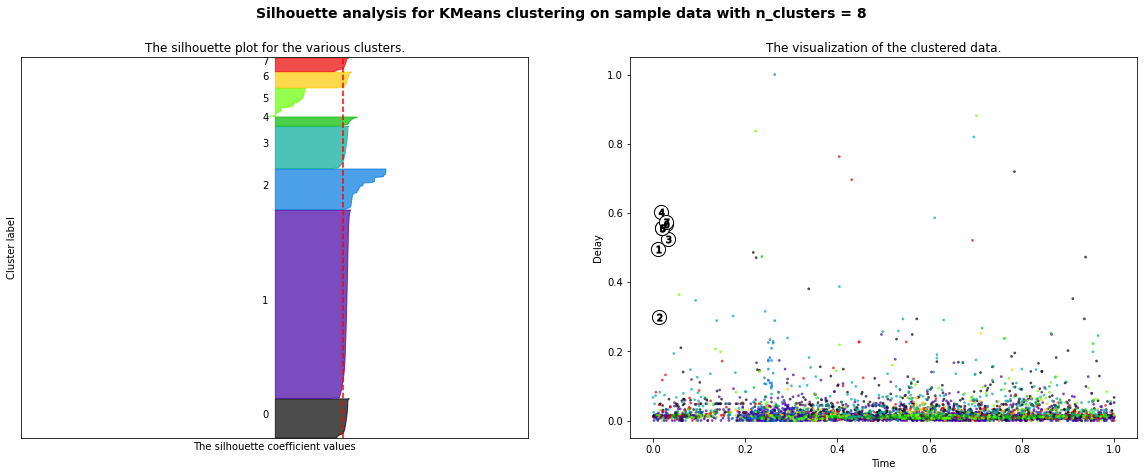

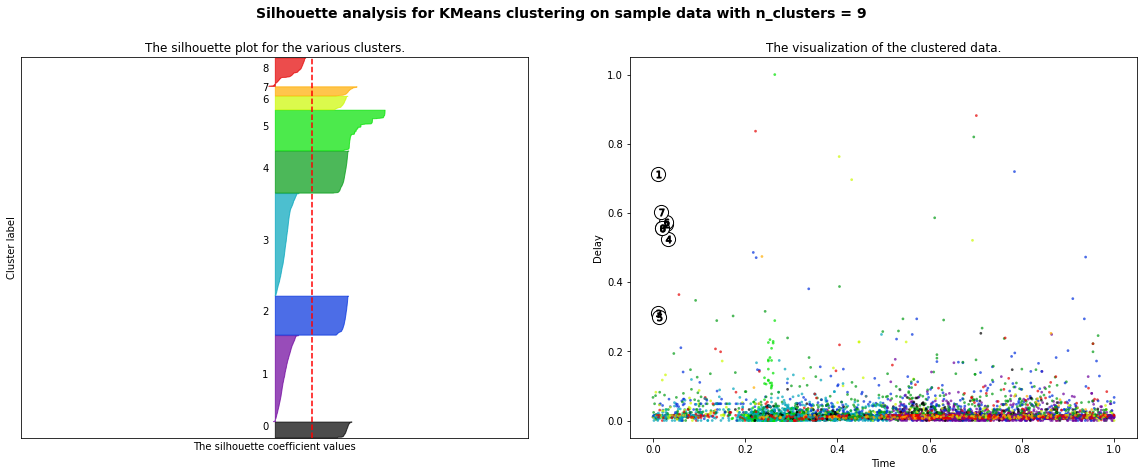

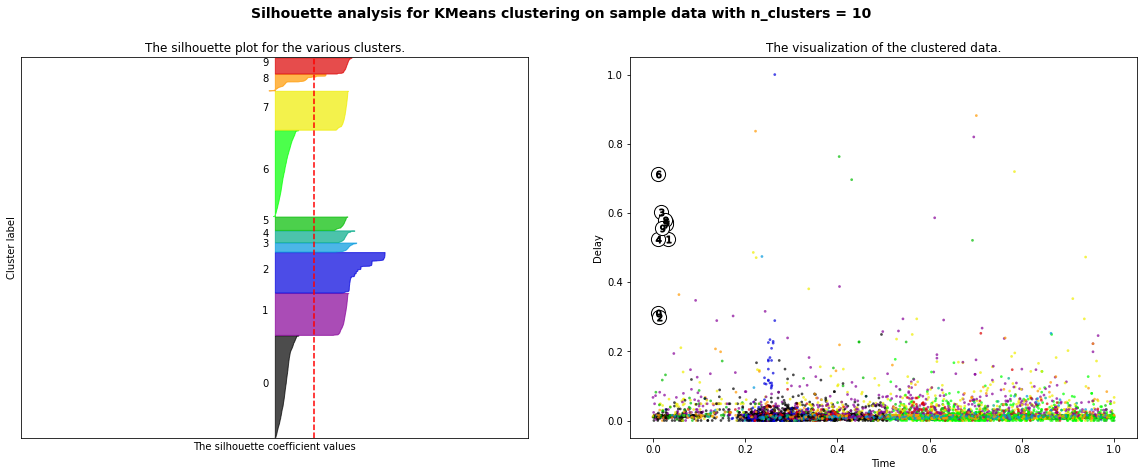

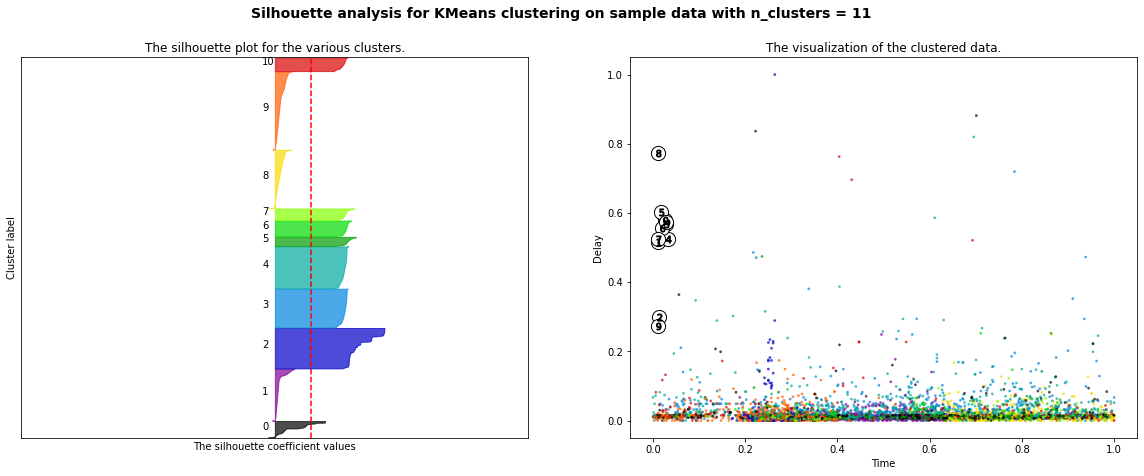

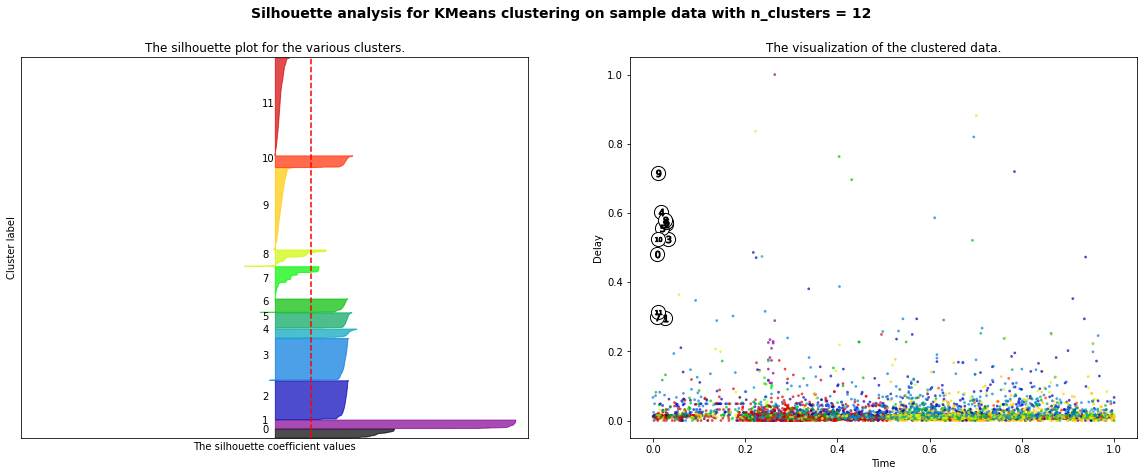

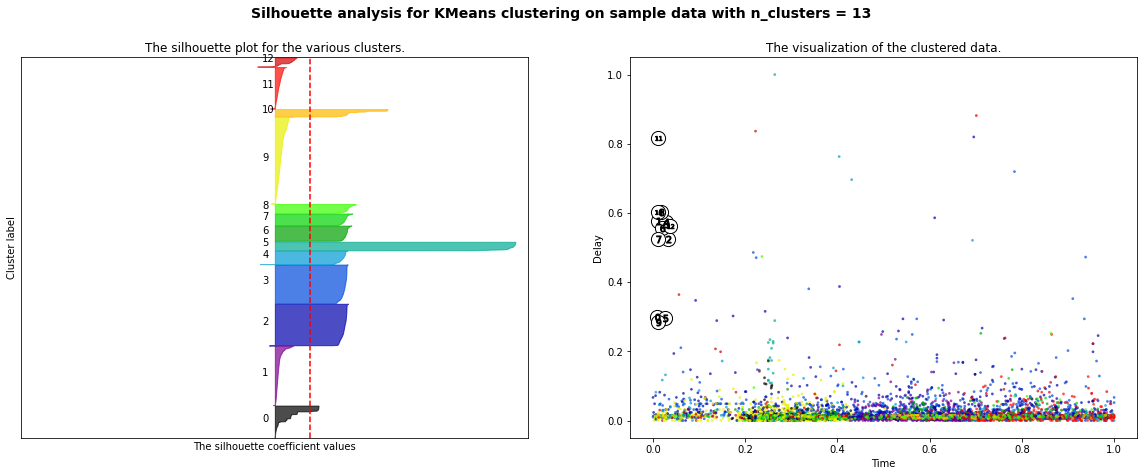

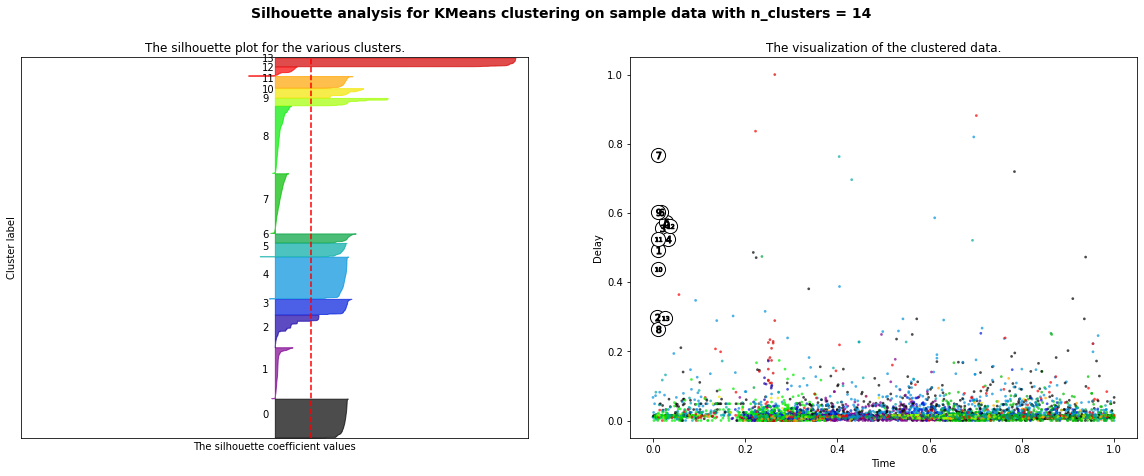

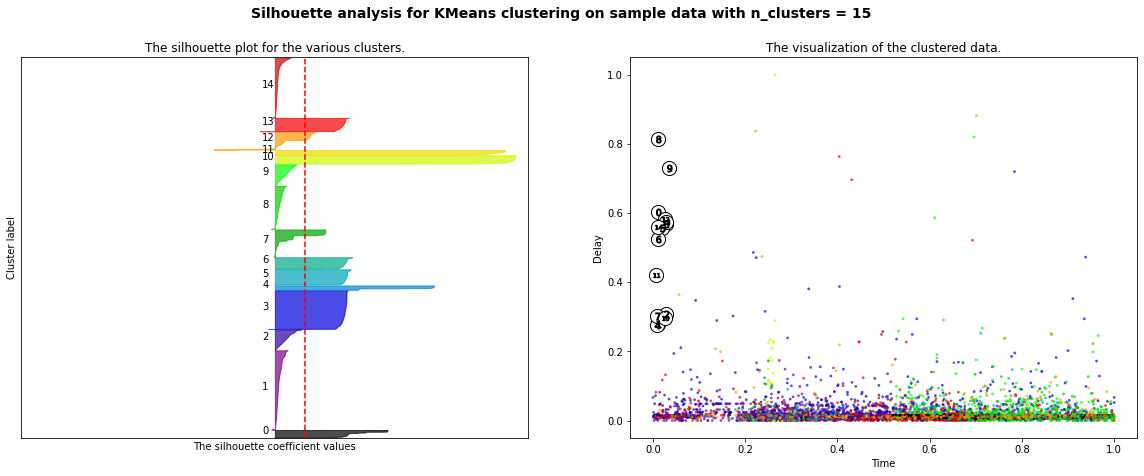

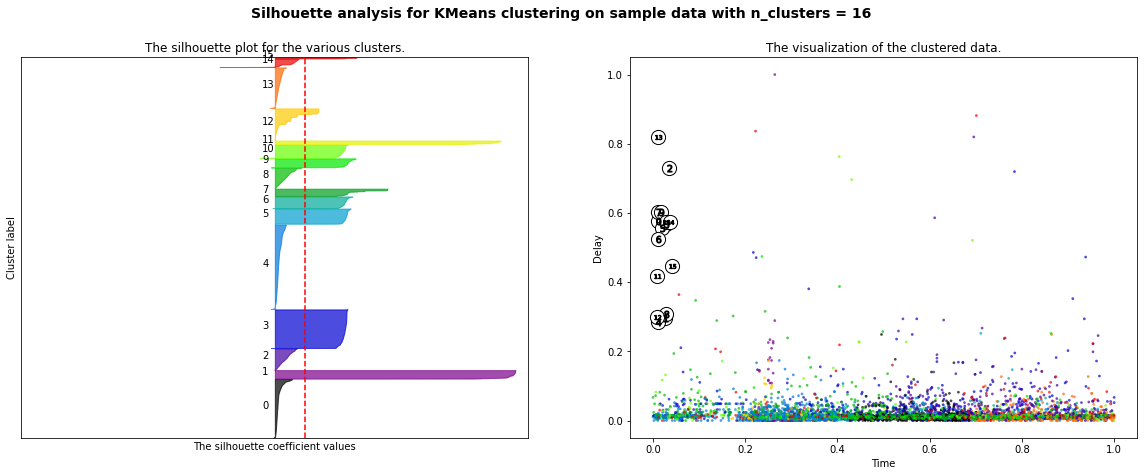

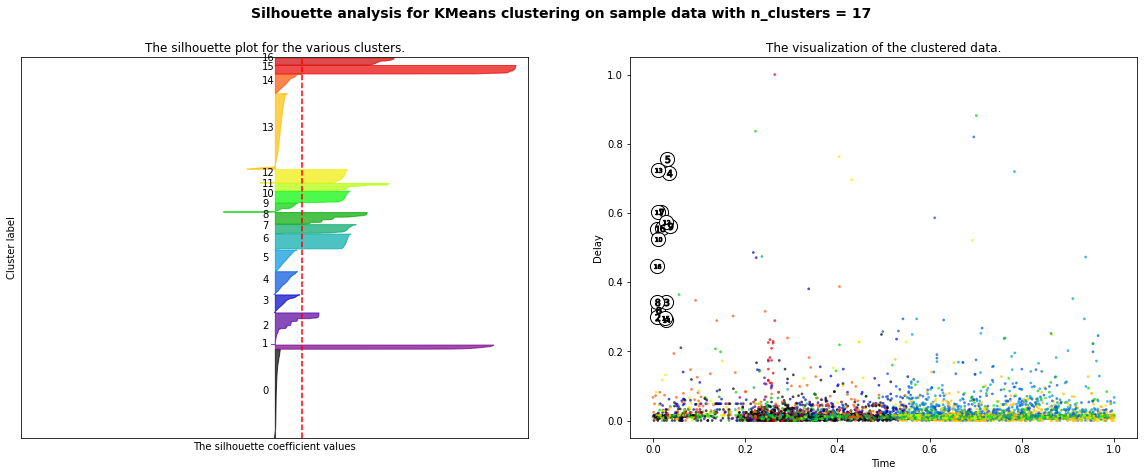

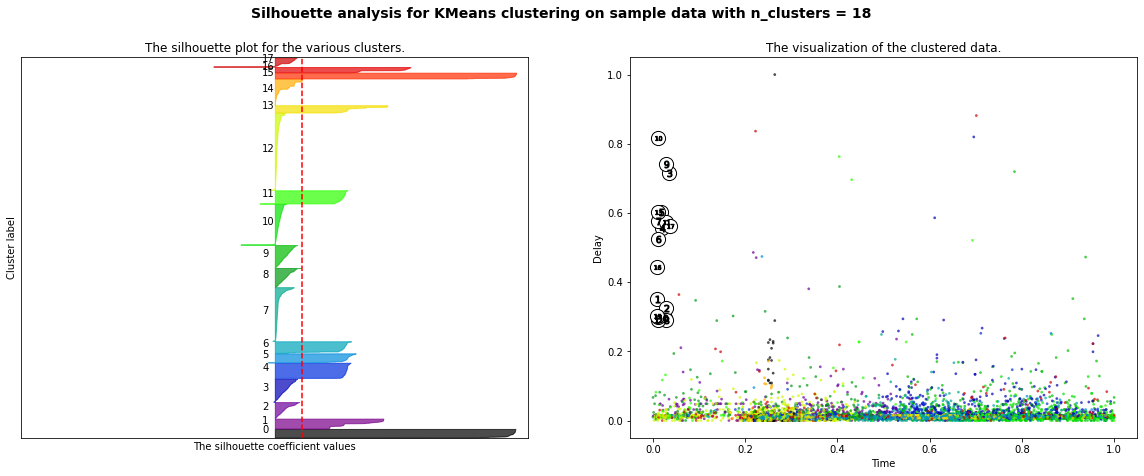

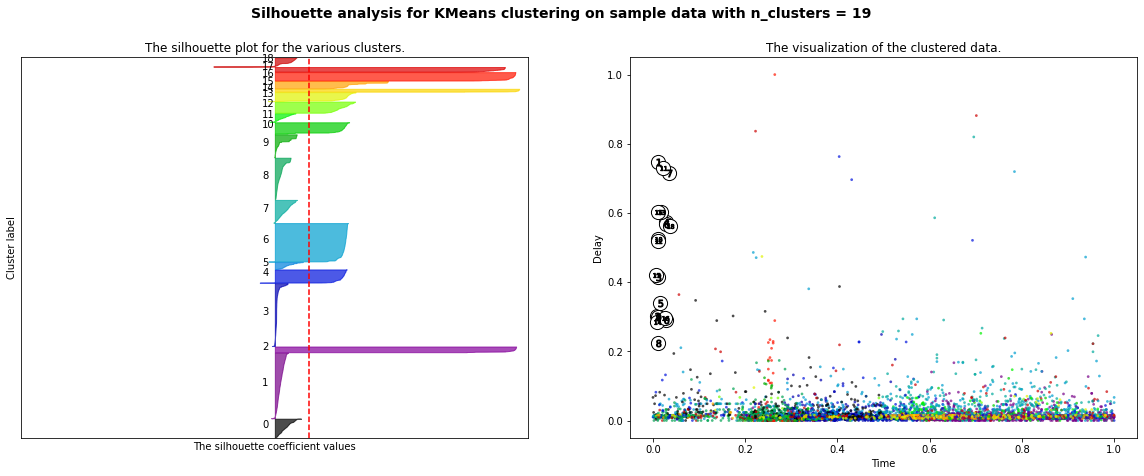

In [118]:
X, y = IL_dummy['Time_in_hours'], IL_dummy['Min_Delay']

for k in range(5,20):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(IL_dummy)
    cluster_labels = clusterer.predict(IL_dummy)
    
    silhouette_avg = silhouette_score(IL_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(IL_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        IL_dummy['Time_in_hours'],IL_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Delay")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    